# Caltech101 Dataset Classification
https://pytorch.org/vision/stable/generated/torchvision.datasets.Caltech101.html

## Setup

In [1]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !unzip /content/drive/MyDrive/ece285_project/DataSets/UCMerced_LandUse.zip -d /content/drive/MyDrive/ece285_project/DataSets/

In [3]:
import os
import json
import time
import copy
from collections import Counter
import pickle
from imutils import paths
from tqdm import tqdm

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split, Subset
# from torchvision.transforms import ToTensor, Resize
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

plt.ion()

import sys
sys.path.append('/content/drive/MyDrive/ece285_project/other_projects/SimCLR_v1/')
from models.resnet_simclr import ResNetSimCLR

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Loading Data

In [ ]:
train_transforms = transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Resize((224, 224))
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

test_transforms = transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Resize((224, 224))
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

In [ ]:
# !tar -xvf '/content/drive/MyDrive/ece285_project/DataSets/caltech101/101_ObjectCategories.tar.gz' -C '/content/drive/MyDrive/ece285_project/DataSets/caltech101'
# !tar -xvf '/content/drive/MyDrive/ece285_project/DataSets/caltech101/Annotations.tar' -C '/content/drive/MyDrive/ece285_project/DataSets/caltech101'

In [ ]:
# dataset = datasets.Caltech101(
#     root="/content/drive/MyDrive/ece285_project/DataSets",
#     # split='trainval',
#     download=False,
#     transform=train_transforms
# )

In [ ]:
image_paths = list(paths.list_images('/content/drive/MyDrive/ece285_project/DataSets/caltech101/101_ObjectCategories'))

data = []
labels = []
for img_path in tqdm(image_paths):
    label = img_path.split(os.path.sep)[-2]
    if label == "BACKGROUND_Google":
        continue
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    data.append(img)
    labels.append(label)
    
data = np.array(data)
labels = np.array(labels)

100%|██████████| 9144/9144 [1:27:13<00:00,  1.75it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


In [ ]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
print(f"Total Number of Classes: {len(lb.classes_)}")

Total Number of Classes: 101


In [ ]:
# divide the data into train, validation, and test set
(X, x_val , Y, y_val) = train_test_split(data, labels, test_size=0.2,  stratify=labels,random_state=42)
(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=0.25, random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (5205,)
x_test examples: (1736,)
x_val examples: (1736,)


In [ ]:
# custom dataset class
class ImageDataset(Dataset):
    def __init__(self, images, labels= None, transforms = None):
        self.labels = labels
        self.images = images
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        data = self.images[index][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        return (data, self.labels[index])

train_dataset = ImageDataset(x_train, y_train, train_transforms)
valid_dataset = ImageDataset(x_val, y_val, test_transforms)
test_dataset = ImageDataset(x_test, y_test, test_transforms) 

In [ ]:
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

5205
1736
1736


In [ ]:
datasets = {
    'train': train_dataset,
    'valid': valid_dataset,
    'test': test_dataset,
}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'valid', 'test']}

## PyTorch DataLoader

In [ ]:
from torchvision.utils import make_grid

73


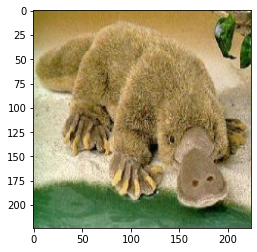

In [ ]:
idx = np.random.choice(len(datasets['train']))

plt.imshow(torch.permute(datasets['train'][idx][0], (1,2,0)))
print(datasets['train'][idx][1])

In [ ]:
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Training and Evaluate Pipeline

In [ ]:
from tqdm import tqdm

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    metrics_dict = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # print(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase=='train':
              metrics_dict['train_loss'].append(epoch_loss)
              metrics_dict['train_acc'].append(epoch_acc.item())
            else:
              metrics_dict['valid_loss'].append(epoch_loss)
              metrics_dict['valid_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics_dict

In [ ]:
def visualize_model(model, dataloaders, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                # ax.set_title(f'predicted: {label_map_rev[preds[j].item()]}')
                plt.imshow(inputs.cpu().data[j].T)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
def evaluate_model(model, dataloader):

    running_corrects = 0

    model.eval()
    with torch.no_grad():

      # Iterate over data.
      for inputs, labels in dataloader:
          # print(inputs)
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)

          # statistics
          running_corrects += torch.sum(preds == labels.data)
          # running_totals += len(labels)
    
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_acc.item()

## Model

In [ ]:
# import torch
# model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

In [ ]:
# model = models.resnet50(pretrained=False)

# # Changing the final layer
# model.fc = nn.Linear(model.fc.in_features, 21)

# model = model.to(device)

## Train and Evaluate

In [ ]:
# BATCH_SIZE = 64
# EPOCHS = 50
# LR_RATE = 0.01
# MOMENTUM = 0.9

In [ ]:
# dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
#                 for x in ['train', 'valid', 'test']}

In [ ]:
# criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=LR_RATE, momentum=MOMENTUM)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)

In [ ]:
# model = train_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

In [ ]:
# evaluate_model(model, dataloaders['test'])

## Linear and Finetuned Evaluation

## Linear Evaluation - Supervised

In [ ]:
BATCH_SIZE = 128
EPOCHS = 100
LR = [0.01] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [ ]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [ ]:
result_le_sv = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/resnet50_cifar10_supervised_e100/resnet.pth'
    model = models.resnet50(pretrained=False)
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
    model.load_state_dict(torch.load(PATH)['net'])
    model = model.module
    model.fc = nn.Linear(model.fc.in_features, 101)
    for name, param in model.named_parameters():
      if 'fc' not in name:
        param.requires_grad = False
    model_le_sv = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_le_sv_best, metrics_dict = train_model(model_le_sv, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_le_sv_best, dataloaders['valid'])
    test_acc = evaluate_model(model_le_sv_best, dataloaders['test'])

    result_le_sv.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
train Loss: 4.2309 Acc: 0.1378


  1%|          | 1/100 [00:25<41:23, 25.09s/it]

valid Loss: 4.0133 Acc: 0.2079

Epoch 1/99
train Loss: 3.9336 Acc: 0.2067


  2%|▏         | 2/100 [00:48<39:35, 24.24s/it]

valid Loss: 3.8556 Acc: 0.2350

Epoch 2/99
train Loss: 3.8033 Acc: 0.2359


  3%|▎         | 3/100 [01:11<38:12, 23.63s/it]

valid Loss: 3.7483 Acc: 0.2523

Epoch 3/99
train Loss: 3.7047 Acc: 0.2465


  4%|▍         | 4/100 [01:34<37:18, 23.31s/it]

valid Loss: 3.6720 Acc: 0.2632

Epoch 4/99
train Loss: 3.6238 Acc: 0.2530


  5%|▌         | 5/100 [01:57<36:38, 23.14s/it]

valid Loss: 3.6069 Acc: 0.2581

Epoch 5/99
train Loss: 3.5552 Acc: 0.2646


  6%|▌         | 6/100 [02:20<36:07, 23.05s/it]

valid Loss: 3.5454 Acc: 0.2702

Epoch 6/99
train Loss: 3.4952 Acc: 0.2699


  7%|▋         | 7/100 [02:43<35:42, 23.03s/it]

valid Loss: 3.4981 Acc: 0.2713

Epoch 7/99
train Loss: 3.4416 Acc: 0.2793


  8%|▊         | 8/100 [03:06<35:13, 22.97s/it]

valid Loss: 3.4502 Acc: 0.2846

Epoch 8/99
train Loss: 3.3912 Acc: 0.2853


  9%|▉         | 9/100 [03:28<34:49, 22.96s/it]

valid Loss: 3.4137 Acc: 0.2851

Epoch 9/99
train Loss: 3.3484 Acc: 0.2891


 10%|█         | 10/100 [03:51<34:23, 22.93s/it]

valid Loss: 3.3748 Acc: 0.2897

Epoch 10/99
train Loss: 3.3067 Acc: 0.2978


 11%|█         | 11/100 [04:14<33:56, 22.89s/it]

valid Loss: 3.3454 Acc: 0.2926

Epoch 11/99
train Loss: 3.2749 Acc: 0.3041


 12%|█▏        | 12/100 [04:37<33:33, 22.88s/it]

valid Loss: 3.3170 Acc: 0.2978

Epoch 12/99
train Loss: 3.2465 Acc: 0.3062


 13%|█▎        | 13/100 [05:00<33:11, 22.89s/it]

valid Loss: 3.2916 Acc: 0.3047

Epoch 13/99
train Loss: 3.2161 Acc: 0.3110


 14%|█▍        | 14/100 [05:23<32:47, 22.88s/it]

valid Loss: 3.2663 Acc: 0.3088

Epoch 14/99
train Loss: 3.1847 Acc: 0.3168


 15%|█▌        | 15/100 [05:46<32:22, 22.85s/it]

valid Loss: 3.2459 Acc: 0.3076

Epoch 15/99
train Loss: 3.1575 Acc: 0.3205


 16%|█▌        | 16/100 [06:08<32:01, 22.87s/it]

valid Loss: 3.2238 Acc: 0.3099

Epoch 16/99
train Loss: 3.1354 Acc: 0.3255


 17%|█▋        | 17/100 [06:31<31:39, 22.89s/it]

valid Loss: 3.2037 Acc: 0.3185

Epoch 17/99
train Loss: 3.1141 Acc: 0.3276


 18%|█▊        | 18/100 [06:55<31:35, 23.12s/it]

valid Loss: 3.1827 Acc: 0.3226

Epoch 18/99
train Loss: 3.0949 Acc: 0.3308


 19%|█▉        | 19/100 [07:18<31:05, 23.03s/it]

valid Loss: 3.1645 Acc: 0.3255

Epoch 19/99
train Loss: 3.0712 Acc: 0.3366


 20%|██        | 20/100 [07:41<30:36, 22.96s/it]

valid Loss: 3.1507 Acc: 0.3249

Epoch 20/99
train Loss: 3.0483 Acc: 0.3422


 21%|██        | 21/100 [08:03<30:11, 22.93s/it]

valid Loss: 3.1340 Acc: 0.3283

Epoch 21/99
train Loss: 3.0341 Acc: 0.3391


 22%|██▏       | 22/100 [08:26<29:44, 22.87s/it]

valid Loss: 3.1229 Acc: 0.3329

Epoch 22/99
train Loss: 3.0183 Acc: 0.3437


 23%|██▎       | 23/100 [08:49<29:22, 22.89s/it]

valid Loss: 3.1065 Acc: 0.3318

Epoch 23/99
train Loss: 3.0051 Acc: 0.3483


 24%|██▍       | 24/100 [09:12<28:59, 22.89s/it]

valid Loss: 3.0944 Acc: 0.3335

Epoch 24/99
train Loss: 2.9881 Acc: 0.3483


 25%|██▌       | 25/100 [09:35<28:36, 22.89s/it]

valid Loss: 3.0844 Acc: 0.3347

Epoch 25/99
train Loss: 2.9721 Acc: 0.3487


 26%|██▌       | 26/100 [09:58<28:15, 22.91s/it]

valid Loss: 3.0740 Acc: 0.3410

Epoch 26/99
train Loss: 2.9565 Acc: 0.3543


 27%|██▋       | 27/100 [10:21<27:48, 22.85s/it]

valid Loss: 3.0601 Acc: 0.3404

Epoch 27/99
train Loss: 2.9428 Acc: 0.3577


 28%|██▊       | 28/100 [10:43<27:24, 22.84s/it]

valid Loss: 3.0480 Acc: 0.3370

Epoch 28/99
train Loss: 2.9316 Acc: 0.3566


 29%|██▉       | 29/100 [11:06<27:02, 22.85s/it]

valid Loss: 3.0400 Acc: 0.3404

Epoch 29/99
train Loss: 2.9185 Acc: 0.3593


 30%|███       | 30/100 [11:29<26:38, 22.83s/it]

valid Loss: 3.0266 Acc: 0.3491

Epoch 30/99
train Loss: 2.9048 Acc: 0.3612


 31%|███       | 31/100 [11:52<26:15, 22.83s/it]

valid Loss: 3.0196 Acc: 0.3462

Epoch 31/99
train Loss: 2.8910 Acc: 0.3668


 32%|███▏      | 32/100 [12:15<25:51, 22.82s/it]

valid Loss: 3.0110 Acc: 0.3485

Epoch 32/99
train Loss: 2.8860 Acc: 0.3656


 33%|███▎      | 33/100 [12:38<25:42, 23.02s/it]

valid Loss: 3.0005 Acc: 0.3479

Epoch 33/99
train Loss: 2.8768 Acc: 0.3671


 34%|███▍      | 34/100 [13:01<25:15, 22.96s/it]

valid Loss: 2.9930 Acc: 0.3520

Epoch 34/99
train Loss: 2.8677 Acc: 0.3662


 35%|███▌      | 35/100 [13:24<24:49, 22.92s/it]

valid Loss: 2.9902 Acc: 0.3548

Epoch 35/99
train Loss: 2.8555 Acc: 0.3712


 36%|███▌      | 36/100 [13:47<24:25, 22.90s/it]

valid Loss: 2.9773 Acc: 0.3531

Epoch 36/99
train Loss: 2.8444 Acc: 0.3727


 37%|███▋      | 37/100 [14:09<23:59, 22.85s/it]

valid Loss: 2.9695 Acc: 0.3577

Epoch 37/99
train Loss: 2.8339 Acc: 0.3758


 38%|███▊      | 38/100 [14:32<23:34, 22.81s/it]

valid Loss: 2.9624 Acc: 0.3577

Epoch 38/99
train Loss: 2.8282 Acc: 0.3781


 39%|███▉      | 39/100 [14:55<23:11, 22.81s/it]

valid Loss: 2.9580 Acc: 0.3583

Epoch 39/99
train Loss: 2.8216 Acc: 0.3758


 40%|████      | 40/100 [15:18<22:47, 22.80s/it]

valid Loss: 2.9483 Acc: 0.3577

Epoch 40/99
train Loss: 2.8110 Acc: 0.3789


 41%|████      | 41/100 [15:40<22:24, 22.79s/it]

valid Loss: 2.9429 Acc: 0.3612

Epoch 41/99
train Loss: 2.8031 Acc: 0.3794


 42%|████▏     | 42/100 [16:03<22:01, 22.78s/it]

valid Loss: 2.9372 Acc: 0.3618

Epoch 42/99
train Loss: 2.7891 Acc: 0.3839


 43%|████▎     | 43/100 [16:26<21:37, 22.77s/it]

valid Loss: 2.9342 Acc: 0.3594

Epoch 43/99
train Loss: 2.7866 Acc: 0.3806


 44%|████▍     | 44/100 [16:49<21:15, 22.78s/it]

valid Loss: 2.9239 Acc: 0.3571

Epoch 44/99
train Loss: 2.7797 Acc: 0.3837


 45%|████▌     | 45/100 [17:12<20:53, 22.78s/it]

valid Loss: 2.9225 Acc: 0.3658

Epoch 45/99
train Loss: 2.7705 Acc: 0.3817


 46%|████▌     | 46/100 [17:34<20:28, 22.75s/it]

valid Loss: 2.9143 Acc: 0.3606

Epoch 46/99
train Loss: 2.7691 Acc: 0.3829


 47%|████▋     | 47/100 [17:58<20:18, 22.98s/it]

valid Loss: 2.9115 Acc: 0.3629

Epoch 47/99
train Loss: 2.7616 Acc: 0.3858


 48%|████▊     | 48/100 [18:21<19:51, 22.91s/it]

valid Loss: 2.9095 Acc: 0.3646

Epoch 48/99
train Loss: 2.7473 Acc: 0.3898


 49%|████▉     | 49/100 [18:43<19:24, 22.84s/it]

valid Loss: 2.9030 Acc: 0.3646

Epoch 49/99
train Loss: 2.7452 Acc: 0.3889


 50%|█████     | 50/100 [19:06<19:00, 22.80s/it]

valid Loss: 2.8958 Acc: 0.3710

Epoch 50/99
train Loss: 2.7365 Acc: 0.3908


 51%|█████     | 51/100 [19:29<18:35, 22.76s/it]

valid Loss: 2.8919 Acc: 0.3652

Epoch 51/99
train Loss: 2.7279 Acc: 0.3912


 52%|█████▏    | 52/100 [19:51<18:11, 22.74s/it]

valid Loss: 2.8838 Acc: 0.3675

Epoch 52/99
train Loss: 2.7238 Acc: 0.3937


 53%|█████▎    | 53/100 [20:14<17:49, 22.76s/it]

valid Loss: 2.8788 Acc: 0.3744

Epoch 53/99
train Loss: 2.7227 Acc: 0.3935


 54%|█████▍    | 54/100 [20:37<17:27, 22.77s/it]

valid Loss: 2.8789 Acc: 0.3756

Epoch 54/99
train Loss: 2.7133 Acc: 0.3948


 55%|█████▌    | 55/100 [21:00<17:04, 22.76s/it]

valid Loss: 2.8691 Acc: 0.3704

Epoch 55/99
train Loss: 2.7090 Acc: 0.3933


 56%|█████▌    | 56/100 [21:22<16:40, 22.75s/it]

valid Loss: 2.8654 Acc: 0.3715

Epoch 56/99
train Loss: 2.6994 Acc: 0.4002


 57%|█████▋    | 57/100 [21:45<16:19, 22.78s/it]

valid Loss: 2.8635 Acc: 0.3785

Epoch 57/99
train Loss: 2.6944 Acc: 0.3954


 58%|█████▊    | 58/100 [22:09<16:04, 22.97s/it]

valid Loss: 2.8597 Acc: 0.3721

Epoch 58/99
train Loss: 2.6911 Acc: 0.3962


 59%|█████▉    | 59/100 [22:31<15:38, 22.90s/it]

valid Loss: 2.8611 Acc: 0.3796

Epoch 59/99
train Loss: 2.6892 Acc: 0.3987


 60%|██████    | 60/100 [22:54<15:14, 22.85s/it]

valid Loss: 2.8540 Acc: 0.3762

Epoch 60/99
train Loss: 2.6800 Acc: 0.4015


 61%|██████    | 61/100 [23:17<14:49, 22.80s/it]

valid Loss: 2.8505 Acc: 0.3790

Epoch 61/99
train Loss: 2.6773 Acc: 0.4017


 62%|██████▏   | 62/100 [23:39<14:25, 22.78s/it]

valid Loss: 2.8449 Acc: 0.3802

Epoch 62/99
train Loss: 2.6746 Acc: 0.4002


 63%|██████▎   | 63/100 [24:02<14:02, 22.76s/it]

valid Loss: 2.8404 Acc: 0.3790

Epoch 63/99
train Loss: 2.6661 Acc: 0.4048


 64%|██████▍   | 64/100 [24:25<13:38, 22.74s/it]

valid Loss: 2.8392 Acc: 0.3813

Epoch 64/99
train Loss: 2.6647 Acc: 0.4023


 65%|██████▌   | 65/100 [24:49<13:32, 23.22s/it]

valid Loss: 2.8351 Acc: 0.3802

Epoch 65/99
train Loss: 2.6582 Acc: 0.4058


 66%|██████▌   | 66/100 [25:12<13:06, 23.13s/it]

valid Loss: 2.8330 Acc: 0.3831

Epoch 66/99
train Loss: 2.6605 Acc: 0.4031


 67%|██████▋   | 67/100 [25:35<12:44, 23.16s/it]

valid Loss: 2.8322 Acc: 0.3808

Epoch 67/99
train Loss: 2.6484 Acc: 0.4065


 68%|██████▊   | 68/100 [25:59<12:22, 23.20s/it]

valid Loss: 2.8274 Acc: 0.3790

Epoch 68/99
train Loss: 2.6466 Acc: 0.4085


 69%|██████▉   | 69/100 [26:21<11:54, 23.05s/it]

valid Loss: 2.8250 Acc: 0.3894

Epoch 69/99
train Loss: 2.6395 Acc: 0.4079


 70%|███████   | 70/100 [26:44<11:28, 22.96s/it]

valid Loss: 2.8223 Acc: 0.3859

Epoch 70/99
train Loss: 2.6369 Acc: 0.4086


 71%|███████   | 71/100 [27:07<11:04, 22.90s/it]

valid Loss: 2.8184 Acc: 0.3877

Epoch 71/99
train Loss: 2.6323 Acc: 0.4104


 72%|███████▏  | 72/100 [27:30<10:39, 22.83s/it]

valid Loss: 2.8138 Acc: 0.3848

Epoch 72/99
train Loss: 2.6310 Acc: 0.4094


 73%|███████▎  | 73/100 [27:52<10:16, 22.82s/it]

valid Loss: 2.8100 Acc: 0.3842

Epoch 73/99
train Loss: 2.6250 Acc: 0.4098


 74%|███████▍  | 74/100 [28:16<09:58, 23.00s/it]

valid Loss: 2.8103 Acc: 0.3854

Epoch 74/99
train Loss: 2.6228 Acc: 0.4085


 75%|███████▌  | 75/100 [28:39<09:33, 22.94s/it]

valid Loss: 2.8089 Acc: 0.3877

Epoch 75/99
train Loss: 2.6189 Acc: 0.4079


 76%|███████▌  | 76/100 [29:01<09:09, 22.89s/it]

valid Loss: 2.8054 Acc: 0.3888

Epoch 76/99
train Loss: 2.6141 Acc: 0.4129


 77%|███████▋  | 77/100 [29:24<08:44, 22.79s/it]

valid Loss: 2.8030 Acc: 0.3859

Epoch 77/99
train Loss: 2.6089 Acc: 0.4136


 78%|███████▊  | 78/100 [29:47<08:20, 22.74s/it]

valid Loss: 2.7989 Acc: 0.3888

Epoch 78/99
train Loss: 2.6072 Acc: 0.4144


 79%|███████▉  | 79/100 [30:09<07:57, 22.76s/it]

valid Loss: 2.7959 Acc: 0.3882

Epoch 79/99
train Loss: 2.6078 Acc: 0.4154


 80%|████████  | 80/100 [30:32<07:34, 22.70s/it]

valid Loss: 2.7953 Acc: 0.3894

Epoch 80/99
train Loss: 2.6023 Acc: 0.4111


 81%|████████  | 81/100 [30:54<07:10, 22.66s/it]

valid Loss: 2.7928 Acc: 0.3894

Epoch 81/99
train Loss: 2.6043 Acc: 0.4161


 82%|████████▏ | 82/100 [31:17<06:47, 22.65s/it]

valid Loss: 2.7906 Acc: 0.3906

Epoch 82/99
train Loss: 2.5965 Acc: 0.4134


 83%|████████▎ | 83/100 [31:40<06:24, 22.62s/it]

valid Loss: 2.7854 Acc: 0.3917

Epoch 83/99
train Loss: 2.5926 Acc: 0.4181


 84%|████████▍ | 84/100 [32:02<06:03, 22.69s/it]

valid Loss: 2.7889 Acc: 0.3940

Epoch 84/99
train Loss: 2.5906 Acc: 0.4192


 85%|████████▌ | 85/100 [32:25<05:40, 22.72s/it]

valid Loss: 2.7851 Acc: 0.3923

Epoch 85/99
train Loss: 2.5899 Acc: 0.4175


 86%|████████▌ | 86/100 [32:48<05:18, 22.74s/it]

valid Loss: 2.7815 Acc: 0.3929

Epoch 86/99
train Loss: 2.5866 Acc: 0.4181


 87%|████████▋ | 87/100 [33:11<04:58, 22.93s/it]

valid Loss: 2.7835 Acc: 0.3923

Epoch 87/99
train Loss: 2.5809 Acc: 0.4188


 88%|████████▊ | 88/100 [33:34<04:33, 22.80s/it]

valid Loss: 2.7783 Acc: 0.3911

Epoch 88/99
train Loss: 2.5779 Acc: 0.4229


 89%|████████▉ | 89/100 [33:57<04:10, 22.80s/it]

valid Loss: 2.7743 Acc: 0.3906

Epoch 89/99
train Loss: 2.5768 Acc: 0.4152


 90%|█████████ | 90/100 [34:20<03:48, 22.80s/it]

valid Loss: 2.7727 Acc: 0.3888

Epoch 90/99
train Loss: 2.5813 Acc: 0.4200


 91%|█████████ | 91/100 [34:42<03:25, 22.78s/it]

valid Loss: 2.7732 Acc: 0.3957

Epoch 91/99
train Loss: 2.5650 Acc: 0.4232


 92%|█████████▏| 92/100 [35:05<03:02, 22.75s/it]

valid Loss: 2.7692 Acc: 0.3946

Epoch 92/99
train Loss: 2.5669 Acc: 0.4221


 93%|█████████▎| 93/100 [35:28<02:39, 22.75s/it]

valid Loss: 2.7703 Acc: 0.3957

Epoch 93/99
train Loss: 2.5625 Acc: 0.4204


 94%|█████████▍| 94/100 [35:50<02:16, 22.72s/it]

valid Loss: 2.7673 Acc: 0.3946

Epoch 94/99
train Loss: 2.5639 Acc: 0.4206


 95%|█████████▌| 95/100 [36:13<01:53, 22.74s/it]

valid Loss: 2.7666 Acc: 0.3975

Epoch 95/99
train Loss: 2.5576 Acc: 0.4223


 96%|█████████▌| 96/100 [36:37<01:32, 23.03s/it]

valid Loss: 2.7608 Acc: 0.3957

Epoch 96/99
train Loss: 2.5554 Acc: 0.4238


 97%|█████████▋| 97/100 [37:00<01:08, 22.95s/it]

valid Loss: 2.7618 Acc: 0.3986

Epoch 97/99
train Loss: 2.5520 Acc: 0.4240


 98%|█████████▊| 98/100 [37:22<00:45, 22.86s/it]

valid Loss: 2.7583 Acc: 0.3975

Epoch 98/99
train Loss: 2.5484 Acc: 0.4227


 99%|█████████▉| 99/100 [37:45<00:22, 22.82s/it]

valid Loss: 2.7551 Acc: 0.3940

Epoch 99/99
train Loss: 2.5502 Acc: 0.4238


100%|██████████| 100/100 [38:08<00:00, 22.88s/it]

valid Loss: 2.7543 Acc: 0.3963

Training complete in 38m 8s
Best val Acc: 0.398618


In [ ]:
result_df = pd.DataFrame(result_le_sv, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.01,0.0001,0.398618,0.406106,"{'train_loss': [4.230864051943439, 3.933593291..."


In [ ]:
import pickle

In [ ]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/caltech101_result_le_sv.pkl')

## Linear Evaluation - SSL

In [ ]:
BATCH_SIZE = 128
EPOCHS = 100
LR = [0.01] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [ ]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [ ]:
result_le_ssl = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/simclr_cifar_10_resnet50_100e/checkpoint_0100.pth.tar'
    model = ResNetSimCLR('resnet50', 128)
    model.load_state_dict(torch.load(PATH)['state_dict'])
    model = model.backbone
    model.fc = nn.Linear(model.fc[2].in_features, 101)
    for name, param in model.named_parameters():
      if 'fc' not in name:
        param.requires_grad = False
    model_le_ssl = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_le_ssl_best, metrics_dict = train_model(model_le_ssl, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_le_ssl_best, dataloaders['valid'])
    test_acc = evaluate_model(model_le_ssl_best, dataloaders['test'])

    result_le_ssl.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
train Loss: 4.1094 Acc: 0.1452


  1%|          | 1/100 [00:24<40:04, 24.29s/it]

valid Loss: 3.7731 Acc: 0.2425

Epoch 1/99
train Loss: 3.6567 Acc: 0.2457


  2%|▏         | 2/100 [00:45<37:01, 22.67s/it]

valid Loss: 3.5073 Acc: 0.2753

Epoch 2/99
train Loss: 3.4303 Acc: 0.2730


  3%|▎         | 3/100 [01:07<35:37, 22.04s/it]

valid Loss: 3.3402 Acc: 0.2892

Epoch 3/99
train Loss: 3.2727 Acc: 0.2909


  4%|▍         | 4/100 [01:28<34:47, 21.74s/it]

valid Loss: 3.2101 Acc: 0.3093

Epoch 4/99
train Loss: 3.1590 Acc: 0.3061


  5%|▌         | 5/100 [01:49<34:11, 21.60s/it]

valid Loss: 3.1164 Acc: 0.3255

Epoch 5/99
train Loss: 3.0639 Acc: 0.3228


  6%|▌         | 6/100 [02:11<33:41, 21.50s/it]

valid Loss: 3.0322 Acc: 0.3381

Epoch 6/99
train Loss: 2.9871 Acc: 0.3395


  7%|▋         | 7/100 [02:32<33:13, 21.44s/it]

valid Loss: 2.9709 Acc: 0.3358

Epoch 7/99
train Loss: 2.9176 Acc: 0.3454


  8%|▊         | 8/100 [02:53<32:47, 21.39s/it]

valid Loss: 2.9111 Acc: 0.3618

Epoch 8/99
train Loss: 2.8573 Acc: 0.3575


  9%|▉         | 9/100 [03:15<32:41, 21.55s/it]

valid Loss: 2.8601 Acc: 0.3664

Epoch 9/99
train Loss: 2.8036 Acc: 0.3708


 10%|█         | 10/100 [03:36<32:12, 21.47s/it]

valid Loss: 2.8273 Acc: 0.3900

Epoch 10/99
train Loss: 2.7575 Acc: 0.3771


 11%|█         | 11/100 [03:58<31:49, 21.45s/it]

valid Loss: 2.7760 Acc: 0.3911

Epoch 11/99
train Loss: 2.7248 Acc: 0.3827


 12%|█▏        | 12/100 [04:19<31:24, 21.42s/it]

valid Loss: 2.7494 Acc: 0.3917

Epoch 12/99
train Loss: 2.6918 Acc: 0.3937


 13%|█▎        | 13/100 [04:41<31:03, 21.42s/it]

valid Loss: 2.7189 Acc: 0.3969

Epoch 13/99
train Loss: 2.6583 Acc: 0.3958


 14%|█▍        | 14/100 [05:02<30:42, 21.43s/it]

valid Loss: 2.6932 Acc: 0.4078

Epoch 14/99
train Loss: 2.6283 Acc: 0.4010


 15%|█▌        | 15/100 [05:23<30:18, 21.39s/it]

valid Loss: 2.6711 Acc: 0.4147

Epoch 15/99
train Loss: 2.6055 Acc: 0.4069


 16%|█▌        | 16/100 [05:45<29:55, 21.37s/it]

valid Loss: 2.6474 Acc: 0.4188

Epoch 16/99
train Loss: 2.5813 Acc: 0.4175


 17%|█▋        | 17/100 [06:06<29:31, 21.34s/it]

valid Loss: 2.6334 Acc: 0.4182

Epoch 17/99
train Loss: 2.5529 Acc: 0.4171


 18%|█▊        | 18/100 [06:27<29:11, 21.36s/it]

valid Loss: 2.6131 Acc: 0.4378

Epoch 18/99
train Loss: 2.5428 Acc: 0.4206


 19%|█▉        | 19/100 [06:49<28:56, 21.44s/it]

valid Loss: 2.5942 Acc: 0.4297

Epoch 19/99
train Loss: 2.5118 Acc: 0.4257


 20%|██        | 20/100 [07:10<28:35, 21.44s/it]

valid Loss: 2.5760 Acc: 0.4338

Epoch 20/99
train Loss: 2.4898 Acc: 0.4315


 21%|██        | 21/100 [07:33<28:31, 21.67s/it]

valid Loss: 2.5620 Acc: 0.4435

Epoch 21/99
train Loss: 2.4681 Acc: 0.4350


 22%|██▏       | 22/100 [07:54<28:04, 21.59s/it]

valid Loss: 2.5438 Acc: 0.4303

Epoch 22/99
train Loss: 2.4591 Acc: 0.4367


 23%|██▎       | 23/100 [08:15<27:38, 21.53s/it]

valid Loss: 2.5357 Acc: 0.4522

Epoch 23/99
train Loss: 2.4441 Acc: 0.4398


 24%|██▍       | 24/100 [08:37<27:14, 21.51s/it]

valid Loss: 2.5204 Acc: 0.4395

Epoch 24/99
train Loss: 2.4291 Acc: 0.4405


 25%|██▌       | 25/100 [08:58<26:51, 21.48s/it]

valid Loss: 2.5059 Acc: 0.4470

Epoch 25/99
train Loss: 2.4111 Acc: 0.4405


 26%|██▌       | 26/100 [09:20<26:29, 21.48s/it]

valid Loss: 2.4943 Acc: 0.4459

Epoch 26/99
train Loss: 2.3972 Acc: 0.4446


 27%|██▋       | 27/100 [09:41<26:08, 21.48s/it]

valid Loss: 2.4873 Acc: 0.4459

Epoch 27/99
train Loss: 2.3879 Acc: 0.4496


 28%|██▊       | 28/100 [10:03<25:46, 21.47s/it]

valid Loss: 2.4770 Acc: 0.4539

Epoch 28/99
train Loss: 2.3728 Acc: 0.4524


 29%|██▉       | 29/100 [10:24<25:19, 21.41s/it]

valid Loss: 2.4640 Acc: 0.4533

Epoch 29/99
train Loss: 2.3610 Acc: 0.4549


 30%|███       | 30/100 [10:45<25:00, 21.43s/it]

valid Loss: 2.4529 Acc: 0.4464

Epoch 30/99
train Loss: 2.3498 Acc: 0.4596


 31%|███       | 31/100 [11:07<24:37, 21.41s/it]

valid Loss: 2.4493 Acc: 0.4579

Epoch 31/99
train Loss: 2.3367 Acc: 0.4624


 32%|███▏      | 32/100 [11:28<24:13, 21.38s/it]

valid Loss: 2.4361 Acc: 0.4660

Epoch 32/99
train Loss: 2.3272 Acc: 0.4621


 33%|███▎      | 33/100 [11:50<24:01, 21.52s/it]

valid Loss: 2.4296 Acc: 0.4666

Epoch 33/99
train Loss: 2.3215 Acc: 0.4642


 34%|███▍      | 34/100 [12:13<24:11, 21.99s/it]

valid Loss: 2.4210 Acc: 0.4597

Epoch 34/99
train Loss: 2.3079 Acc: 0.4684


 35%|███▌      | 35/100 [12:37<24:21, 22.48s/it]

valid Loss: 2.4225 Acc: 0.4700

Epoch 35/99
train Loss: 2.2997 Acc: 0.4695


 36%|███▌      | 36/100 [12:58<23:39, 22.18s/it]

valid Loss: 2.4062 Acc: 0.4706

Epoch 36/99
train Loss: 2.2899 Acc: 0.4692


 37%|███▋      | 37/100 [13:19<23:02, 21.95s/it]

valid Loss: 2.4018 Acc: 0.4643

Epoch 37/99
train Loss: 2.2838 Acc: 0.4722


 38%|███▊      | 38/100 [13:42<22:42, 21.97s/it]

valid Loss: 2.3963 Acc: 0.4666

Epoch 38/99
train Loss: 2.2815 Acc: 0.4669


 39%|███▉      | 39/100 [14:03<22:10, 21.82s/it]

valid Loss: 2.3869 Acc: 0.4718

Epoch 39/99
train Loss: 2.2658 Acc: 0.4732


 40%|████      | 40/100 [14:24<21:39, 21.66s/it]

valid Loss: 2.3825 Acc: 0.4695

Epoch 40/99
train Loss: 2.2549 Acc: 0.4776


 41%|████      | 41/100 [14:46<21:14, 21.60s/it]

valid Loss: 2.3758 Acc: 0.4787

Epoch 41/99
train Loss: 2.2493 Acc: 0.4799


 42%|████▏     | 42/100 [15:07<20:49, 21.55s/it]

valid Loss: 2.3687 Acc: 0.4764

Epoch 42/99
train Loss: 2.2431 Acc: 0.4817


 43%|████▎     | 43/100 [15:29<20:26, 21.51s/it]

valid Loss: 2.3689 Acc: 0.4856

Epoch 43/99
train Loss: 2.2318 Acc: 0.4826


 44%|████▍     | 44/100 [15:50<20:01, 21.46s/it]

valid Loss: 2.3630 Acc: 0.4775

Epoch 44/99
train Loss: 2.2320 Acc: 0.4828


 45%|████▌     | 45/100 [16:12<19:49, 21.63s/it]

valid Loss: 2.3528 Acc: 0.4810

Epoch 45/99
train Loss: 2.2223 Acc: 0.4874


 46%|████▌     | 46/100 [16:33<19:24, 21.56s/it]

valid Loss: 2.3526 Acc: 0.4873

Epoch 46/99
train Loss: 2.2145 Acc: 0.4826


 47%|████▋     | 47/100 [16:55<18:59, 21.51s/it]

valid Loss: 2.3464 Acc: 0.4833

Epoch 47/99
train Loss: 2.2096 Acc: 0.4876


 48%|████▊     | 48/100 [17:16<18:36, 21.48s/it]

valid Loss: 2.3395 Acc: 0.4833

Epoch 48/99
train Loss: 2.2033 Acc: 0.4926


 49%|████▉     | 49/100 [17:38<18:14, 21.47s/it]

valid Loss: 2.3335 Acc: 0.4862

Epoch 49/99
train Loss: 2.1981 Acc: 0.4899


 50%|█████     | 50/100 [17:59<17:51, 21.44s/it]

valid Loss: 2.3335 Acc: 0.4868

Epoch 50/99
train Loss: 2.1892 Acc: 0.4959


 51%|█████     | 51/100 [18:20<17:30, 21.44s/it]

valid Loss: 2.3317 Acc: 0.4914

Epoch 51/99
train Loss: 2.1856 Acc: 0.4941


 52%|█████▏    | 52/100 [18:42<17:08, 21.42s/it]

valid Loss: 2.3262 Acc: 0.4873

Epoch 52/99
train Loss: 2.1775 Acc: 0.4997


 53%|█████▎    | 53/100 [19:03<16:46, 21.41s/it]

valid Loss: 2.3220 Acc: 0.4885

Epoch 53/99
train Loss: 2.1726 Acc: 0.4984


 54%|█████▍    | 54/100 [19:24<16:23, 21.39s/it]

valid Loss: 2.3189 Acc: 0.4862

Epoch 54/99
train Loss: 2.1715 Acc: 0.4947


 55%|█████▌    | 55/100 [19:46<16:02, 21.40s/it]

valid Loss: 2.3153 Acc: 0.4937

Epoch 55/99
train Loss: 2.1633 Acc: 0.4955


 56%|█████▌    | 56/100 [20:07<15:41, 21.39s/it]

valid Loss: 2.3112 Acc: 0.4908

Epoch 56/99
train Loss: 2.1538 Acc: 0.5007


 57%|█████▋    | 57/100 [20:29<15:28, 21.60s/it]

valid Loss: 2.3074 Acc: 0.4896

Epoch 57/99
train Loss: 2.1567 Acc: 0.4986


 58%|█████▊    | 58/100 [20:51<15:04, 21.53s/it]

valid Loss: 2.3079 Acc: 0.4919

Epoch 58/99
train Loss: 2.1485 Acc: 0.5036


 59%|█████▉    | 59/100 [21:12<14:41, 21.50s/it]

valid Loss: 2.3009 Acc: 0.4954

Epoch 59/99
train Loss: 2.1491 Acc: 0.4986


 60%|██████    | 60/100 [21:34<14:18, 21.46s/it]

valid Loss: 2.2946 Acc: 0.4948

Epoch 60/99
train Loss: 2.1367 Acc: 0.5045


 61%|██████    | 61/100 [21:55<13:56, 21.44s/it]

valid Loss: 2.2977 Acc: 0.4960

Epoch 61/99
train Loss: 2.1386 Acc: 0.5020


 62%|██████▏   | 62/100 [22:16<13:32, 21.39s/it]

valid Loss: 2.2898 Acc: 0.4942

Epoch 62/99
train Loss: 2.1363 Acc: 0.5030


 63%|██████▎   | 63/100 [22:38<13:11, 21.40s/it]

valid Loss: 2.2879 Acc: 0.4965

Epoch 63/99
train Loss: 2.1242 Acc: 0.5097


 64%|██████▍   | 64/100 [22:59<12:49, 21.38s/it]

valid Loss: 2.2852 Acc: 0.4948

Epoch 64/99
train Loss: 2.1203 Acc: 0.5110


 65%|██████▌   | 65/100 [23:20<12:27, 21.35s/it]

valid Loss: 2.2829 Acc: 0.4977

Epoch 65/99
train Loss: 2.1195 Acc: 0.5089


 66%|██████▌   | 66/100 [23:42<12:06, 21.36s/it]

valid Loss: 2.2793 Acc: 0.4994

Epoch 66/99
train Loss: 2.1126 Acc: 0.5118


 67%|██████▋   | 67/100 [24:03<11:46, 21.40s/it]

valid Loss: 2.2756 Acc: 0.5069

Epoch 67/99
train Loss: 2.1144 Acc: 0.5114


 68%|██████▊   | 68/100 [24:24<11:24, 21.38s/it]

valid Loss: 2.2744 Acc: 0.4942

Epoch 68/99
train Loss: 2.1062 Acc: 0.5074


 69%|██████▉   | 69/100 [24:46<11:08, 21.57s/it]

valid Loss: 2.2720 Acc: 0.4971

Epoch 69/99
train Loss: 2.1034 Acc: 0.5141


 70%|███████   | 70/100 [25:08<10:44, 21.50s/it]

valid Loss: 2.2703 Acc: 0.4988

Epoch 70/99
train Loss: 2.0999 Acc: 0.5114


 71%|███████   | 71/100 [25:29<10:22, 21.48s/it]

valid Loss: 2.2627 Acc: 0.5029

Epoch 71/99
train Loss: 2.1031 Acc: 0.5118


 72%|███████▏  | 72/100 [25:51<10:00, 21.46s/it]

valid Loss: 2.2609 Acc: 0.5063

Epoch 72/99
train Loss: 2.0948 Acc: 0.5160


 73%|███████▎  | 73/100 [26:12<09:38, 21.43s/it]

valid Loss: 2.2633 Acc: 0.5017

Epoch 73/99
train Loss: 2.0900 Acc: 0.5141


 74%|███████▍  | 74/100 [26:33<09:17, 21.42s/it]

valid Loss: 2.2602 Acc: 0.5063

Epoch 74/99
train Loss: 2.0868 Acc: 0.5162


 75%|███████▌  | 75/100 [26:55<08:55, 21.42s/it]

valid Loss: 2.2571 Acc: 0.5058

Epoch 75/99
train Loss: 2.0818 Acc: 0.5183


 76%|███████▌  | 76/100 [27:16<08:33, 21.39s/it]

valid Loss: 2.2572 Acc: 0.5006

Epoch 76/99
train Loss: 2.0804 Acc: 0.5189


 77%|███████▋  | 77/100 [27:37<08:11, 21.38s/it]

valid Loss: 2.2508 Acc: 0.5046

Epoch 77/99
train Loss: 2.0753 Acc: 0.5151


 78%|███████▊  | 78/100 [27:59<07:50, 21.40s/it]

valid Loss: 2.2517 Acc: 0.5058

Epoch 78/99
train Loss: 2.0760 Acc: 0.5201


 79%|███████▉  | 79/100 [28:20<07:29, 21.38s/it]

valid Loss: 2.2467 Acc: 0.5075

Epoch 79/99
train Loss: 2.0651 Acc: 0.5218


 80%|████████  | 80/100 [28:42<07:07, 21.39s/it]

valid Loss: 2.2459 Acc: 0.5046

Epoch 80/99
train Loss: 2.0627 Acc: 0.5241


 81%|████████  | 81/100 [29:04<06:49, 21.54s/it]

valid Loss: 2.2437 Acc: 0.5029

Epoch 81/99
train Loss: 2.0650 Acc: 0.5243


 82%|████████▏ | 82/100 [29:25<06:26, 21.49s/it]

valid Loss: 2.2403 Acc: 0.5040

Epoch 82/99
train Loss: 2.0656 Acc: 0.5210


 83%|████████▎ | 83/100 [29:46<06:04, 21.45s/it]

valid Loss: 2.2356 Acc: 0.5069

Epoch 83/99
train Loss: 2.0552 Acc: 0.5243


 84%|████████▍ | 84/100 [30:08<05:42, 21.43s/it]

valid Loss: 2.2373 Acc: 0.5040

Epoch 84/99
train Loss: 2.0550 Acc: 0.5226


 85%|████████▌ | 85/100 [30:29<05:21, 21.45s/it]

valid Loss: 2.2355 Acc: 0.5098

Epoch 85/99
train Loss: 2.0530 Acc: 0.5255


 86%|████████▌ | 86/100 [30:51<05:00, 21.46s/it]

valid Loss: 2.2365 Acc: 0.5069

Epoch 86/99
train Loss: 2.0485 Acc: 0.5260


 87%|████████▋ | 87/100 [31:12<04:38, 21.46s/it]

valid Loss: 2.2324 Acc: 0.5104

Epoch 87/99
train Loss: 2.0458 Acc: 0.5270


 88%|████████▊ | 88/100 [31:34<04:17, 21.44s/it]

valid Loss: 2.2311 Acc: 0.5109

Epoch 88/99
train Loss: 2.0425 Acc: 0.5241


 89%|████████▉ | 89/100 [31:55<03:55, 21.45s/it]

valid Loss: 2.2302 Acc: 0.5040

Epoch 89/99
train Loss: 2.0400 Acc: 0.5262


 90%|█████████ | 90/100 [32:16<03:34, 21.42s/it]

valid Loss: 2.2293 Acc: 0.5081

Epoch 90/99
train Loss: 2.0341 Acc: 0.5291


 91%|█████████ | 91/100 [32:38<03:12, 21.42s/it]

valid Loss: 2.2276 Acc: 0.5121

Epoch 91/99
train Loss: 2.0374 Acc: 0.5285


 92%|█████████▏| 92/100 [33:00<02:52, 21.55s/it]

valid Loss: 2.2258 Acc: 0.5092

Epoch 92/99
train Loss: 2.0313 Acc: 0.5297


 93%|█████████▎| 93/100 [33:21<02:30, 21.51s/it]

valid Loss: 2.2241 Acc: 0.5115

Epoch 93/99
train Loss: 2.0299 Acc: 0.5312


 94%|█████████▍| 94/100 [33:42<02:08, 21.49s/it]

valid Loss: 2.2197 Acc: 0.5109

Epoch 94/99
train Loss: 2.0327 Acc: 0.5262


 95%|█████████▌| 95/100 [34:04<01:47, 21.46s/it]

valid Loss: 2.2169 Acc: 0.5098

Epoch 95/99
train Loss: 2.0325 Acc: 0.5291


 96%|█████████▌| 96/100 [34:25<01:25, 21.47s/it]

valid Loss: 2.2175 Acc: 0.5132

Epoch 96/99
train Loss: 2.0301 Acc: 0.5276


 97%|█████████▋| 97/100 [34:47<01:04, 21.47s/it]

valid Loss: 2.2146 Acc: 0.5081

Epoch 97/99
train Loss: 2.0280 Acc: 0.5281


 98%|█████████▊| 98/100 [35:08<00:42, 21.44s/it]

valid Loss: 2.2141 Acc: 0.5069

Epoch 98/99
train Loss: 2.0197 Acc: 0.5303


 99%|█████████▉| 99/100 [35:30<00:21, 21.41s/it]

valid Loss: 2.2145 Acc: 0.5138

Epoch 99/99
train Loss: 2.0190 Acc: 0.5310


100%|██████████| 100/100 [35:51<00:00, 21.52s/it]

valid Loss: 2.2139 Acc: 0.5081

Training complete in 35m 52s
Best val Acc: 0.513825


In [ ]:
result_df = pd.DataFrame(result_le_ssl, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.01,0.0001,0.513825,0.490207,"{'train_loss': [4.1094423590888205, 3.65672304..."


In [ ]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/caltech101_result_le_ssl.pkl')

## Fine Tuning - Random Init

In [ ]:
def append_dropout(model, rate=0.05):
      for name, module in model.named_children():
          if len(list(module.children())) > 0:
            append_dropout(module)
          if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=False))
            setattr(model, name, new)
          if isinstance(module, nn.Linear):
            new = nn.Sequential(module, nn.Dropout2d(p=0.2, inplace=False))
            setattr(model, name, new)

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
LR = [0.02] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [ ]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [ ]:
result_ft_rand = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    # PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/resnet50_cifar10_supervised_e100/resnet.pth'
    model = models.resnet50(pretrained=False)
    # model = torch.nn.DataParallel(model)
    # cudnn.benchmark = True
    # model.load_state_dict(torch.load(PATH)['net'])
    # model = model.module
    model.fc = nn.Linear(model.fc.in_features, 101)
    # for name, param in model.named_parameters():
    #   if 'fc' not in name:
    #     param.requires_grad = False
    def append_dropout(model, rate=0.05):
      for name, module in model.named_children():
          if len(list(module.children())) > 0:
            append_dropout(module)
          if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=False))
            setattr(model, name, new)
          if isinstance(module, nn.Linear):
            new = nn.Sequential(module, nn.Dropout2d(p=0.2, inplace=False))
            setattr(model, name, new)

    append_dropout(model)
    model_ft_rand = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_ft_rand_best, metrics_dict = train_model(model_ft_rand, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_ft_rand_best, dataloaders['valid'])
    test_acc = evaluate_model(model_ft_rand_best, dataloaders['test'])

    result_ft_rand.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 0/99
train Loss: 7.2076 Acc: 0.0695


  1%|          | 1/100 [00:40<1:06:39, 40.40s/it]

valid Loss: 4.3345 Acc: 0.0927

Epoch 1/99
train Loss: 4.4826 Acc: 0.0891


  2%|▏         | 2/100 [01:20<1:06:00, 40.41s/it]

valid Loss: 4.1877 Acc: 0.0985

Epoch 2/99
train Loss: 4.3208 Acc: 0.1180


  3%|▎         | 3/100 [02:01<1:05:17, 40.39s/it]

valid Loss: 4.1297 Acc: 0.1515

Epoch 3/99
train Loss: 4.2099 Acc: 0.1337


  4%|▍         | 4/100 [02:41<1:04:37, 40.39s/it]

valid Loss: 4.0286 Acc: 0.1740

Epoch 4/99
train Loss: 4.1053 Acc: 0.1470


  5%|▌         | 5/100 [03:22<1:03:58, 40.41s/it]

valid Loss: 4.2961 Acc: 0.1838

Epoch 5/99
train Loss: 3.9964 Acc: 0.1627


  6%|▌         | 6/100 [04:02<1:03:24, 40.47s/it]

valid Loss: 4.4669 Acc: 0.2033

Epoch 6/99
train Loss: 3.8956 Acc: 0.1802


  7%|▋         | 7/100 [04:42<1:02:35, 40.38s/it]

valid Loss: 3.6926 Acc: 0.2287

Epoch 7/99
train Loss: 3.7967 Acc: 0.1952


  8%|▊         | 8/100 [05:23<1:01:50, 40.33s/it]

valid Loss: 3.6276 Acc: 0.2327

Epoch 8/99
train Loss: 3.7522 Acc: 0.2021


  9%|▉         | 9/100 [06:03<1:01:04, 40.27s/it]

valid Loss: 3.5452 Acc: 0.2396

Epoch 9/99
train Loss: 3.6804 Acc: 0.2058


 10%|█         | 10/100 [06:43<1:00:23, 40.26s/it]

valid Loss: 3.4821 Acc: 0.2638

Epoch 10/99
train Loss: 3.6401 Acc: 0.2190


 11%|█         | 11/100 [07:23<59:41, 40.24s/it]  

valid Loss: 3.2846 Acc: 0.2817

Epoch 11/99
train Loss: 3.5046 Acc: 0.2407


 12%|█▏        | 12/100 [08:04<59:09, 40.34s/it]

valid Loss: 3.2563 Acc: 0.2886

Epoch 12/99
train Loss: 3.4505 Acc: 0.2557


 13%|█▎        | 13/100 [08:44<58:24, 40.29s/it]

valid Loss: 3.1138 Acc: 0.3214

Epoch 13/99
train Loss: 3.4203 Acc: 0.2538


 14%|█▍        | 14/100 [09:24<57:43, 40.27s/it]

valid Loss: 3.0069 Acc: 0.3531

Epoch 14/99
train Loss: 3.3230 Acc: 0.2717


 15%|█▌        | 15/100 [10:04<57:02, 40.27s/it]

valid Loss: 2.9536 Acc: 0.3606

Epoch 15/99
train Loss: 3.2431 Acc: 0.2964


 16%|█▌        | 16/100 [10:45<56:20, 40.24s/it]

valid Loss: 2.8345 Acc: 0.3687

Epoch 16/99
train Loss: 3.1888 Acc: 0.2945


 17%|█▋        | 17/100 [11:25<55:38, 40.22s/it]

valid Loss: 2.7986 Acc: 0.3819

Epoch 17/99
train Loss: 3.1384 Acc: 0.3170


 18%|█▊        | 18/100 [12:05<55:03, 40.28s/it]

valid Loss: 2.6982 Acc: 0.4130

Epoch 18/99
train Loss: 3.0201 Acc: 0.3310


 19%|█▉        | 19/100 [12:45<54:18, 40.23s/it]

valid Loss: 2.6562 Acc: 0.4182

Epoch 19/99
train Loss: 2.9274 Acc: 0.3426


 20%|██        | 20/100 [13:25<53:36, 40.21s/it]

valid Loss: 2.6188 Acc: 0.4326

Epoch 20/99
train Loss: 2.8907 Acc: 0.3479


 21%|██        | 21/100 [14:05<52:54, 40.18s/it]

valid Loss: 2.5067 Acc: 0.4395

Epoch 21/99
train Loss: 2.8313 Acc: 0.3639


 22%|██▏       | 22/100 [14:46<52:14, 40.18s/it]

valid Loss: 2.5418 Acc: 0.4435

Epoch 22/99
train Loss: 2.7866 Acc: 0.3769


 23%|██▎       | 23/100 [15:26<51:33, 40.18s/it]

valid Loss: 2.6698 Acc: 0.4516

Epoch 23/99
train Loss: 2.7820 Acc: 0.3704


 24%|██▍       | 24/100 [16:06<50:59, 40.26s/it]

valid Loss: 2.4727 Acc: 0.4672

Epoch 24/99
train Loss: 2.6620 Acc: 0.4008


 25%|██▌       | 25/100 [16:46<50:16, 40.22s/it]

valid Loss: 2.4143 Acc: 0.4597

Epoch 25/99
train Loss: 2.6652 Acc: 0.3935


 26%|██▌       | 26/100 [17:27<49:36, 40.23s/it]

valid Loss: 2.5096 Acc: 0.4735

Epoch 26/99
train Loss: 2.6123 Acc: 0.3992


 27%|██▋       | 27/100 [18:07<48:53, 40.19s/it]

valid Loss: 2.4263 Acc: 0.4683

Epoch 27/99
train Loss: 2.5446 Acc: 0.4159


 28%|██▊       | 28/100 [18:47<48:13, 40.19s/it]

valid Loss: 2.5884 Acc: 0.4804

Epoch 28/99
train Loss: 2.4955 Acc: 0.4202


 29%|██▉       | 29/100 [19:27<47:32, 40.18s/it]

valid Loss: 2.2320 Acc: 0.4879

Epoch 29/99
train Loss: 2.4451 Acc: 0.4292


 30%|███       | 30/100 [20:08<46:59, 40.27s/it]

valid Loss: 2.3690 Acc: 0.4971

Epoch 30/99
train Loss: 2.4081 Acc: 0.4448


 31%|███       | 31/100 [20:48<46:17, 40.25s/it]

valid Loss: 2.2308 Acc: 0.5081

Epoch 31/99
train Loss: 2.3433 Acc: 0.4519


 32%|███▏      | 32/100 [21:28<45:35, 40.23s/it]

valid Loss: 2.1005 Acc: 0.5253

Epoch 32/99
train Loss: 2.3298 Acc: 0.4672


 33%|███▎      | 33/100 [22:08<44:53, 40.20s/it]

valid Loss: 2.1282 Acc: 0.5213

Epoch 33/99
train Loss: 2.2653 Acc: 0.4719


 34%|███▍      | 34/100 [22:48<44:12, 40.19s/it]

valid Loss: 2.1465 Acc: 0.5207

Epoch 34/99
train Loss: 2.1990 Acc: 0.4861


 35%|███▌      | 35/100 [23:28<43:31, 40.18s/it]

valid Loss: 2.0149 Acc: 0.5403

Epoch 35/99
train Loss: 2.1916 Acc: 0.4872


 36%|███▌      | 36/100 [24:09<42:56, 40.25s/it]

valid Loss: 2.0162 Acc: 0.5426

Epoch 36/99
train Loss: 2.0988 Acc: 0.5049


 37%|███▋      | 37/100 [24:49<42:14, 40.22s/it]

valid Loss: 2.0417 Acc: 0.5582

Epoch 37/99
train Loss: 2.0697 Acc: 0.5087


 38%|███▊      | 38/100 [25:29<41:33, 40.21s/it]

valid Loss: 1.8978 Acc: 0.5662

Epoch 38/99
train Loss: 2.0488 Acc: 0.5130


 39%|███▉      | 39/100 [26:09<40:50, 40.18s/it]

valid Loss: 1.9385 Acc: 0.5622

Epoch 39/99
train Loss: 2.0275 Acc: 0.5233


 40%|████      | 40/100 [26:49<40:09, 40.16s/it]

valid Loss: 1.9571 Acc: 0.5582

Epoch 40/99
train Loss: 1.9001 Acc: 0.5541


 41%|████      | 41/100 [27:30<39:28, 40.14s/it]

valid Loss: 1.7617 Acc: 0.5835

Epoch 41/99
train Loss: 1.8979 Acc: 0.5451


 42%|████▏     | 42/100 [28:10<38:52, 40.21s/it]

valid Loss: 1.8535 Acc: 0.5726

Epoch 42/99
train Loss: 1.8660 Acc: 0.5535


 43%|████▎     | 43/100 [28:50<38:10, 40.18s/it]

valid Loss: 1.7944 Acc: 0.5950

Epoch 43/99
train Loss: 1.7884 Acc: 0.5766


 44%|████▍     | 44/100 [29:30<37:29, 40.16s/it]

valid Loss: 1.8900 Acc: 0.5726

Epoch 44/99
train Loss: 1.7848 Acc: 0.5752


 45%|████▌     | 45/100 [30:10<36:48, 40.15s/it]

valid Loss: 1.7728 Acc: 0.5818

Epoch 45/99
train Loss: 1.7553 Acc: 0.5827


 46%|████▌     | 46/100 [30:50<36:08, 40.15s/it]

valid Loss: 2.1013 Acc: 0.5806

Epoch 46/99
train Loss: 1.7250 Acc: 0.5915


 47%|████▋     | 47/100 [31:31<35:28, 40.15s/it]

valid Loss: 1.7626 Acc: 0.5968

Epoch 47/99
train Loss: 1.6795 Acc: 0.6042


 48%|████▊     | 48/100 [32:11<34:52, 40.24s/it]

valid Loss: 1.7946 Acc: 0.5962

Epoch 48/99
train Loss: 1.6391 Acc: 0.6110


 49%|████▉     | 49/100 [32:51<34:11, 40.22s/it]

valid Loss: 1.7410 Acc: 0.5985

Epoch 49/99
train Loss: 1.6232 Acc: 0.6161


 50%|█████     | 50/100 [33:31<33:29, 40.19s/it]

valid Loss: 1.7981 Acc: 0.5933

Epoch 50/99
train Loss: 1.5042 Acc: 0.6417


 51%|█████     | 51/100 [34:11<32:48, 40.18s/it]

valid Loss: 1.6708 Acc: 0.6146

Epoch 51/99
train Loss: 1.4942 Acc: 0.6467


 52%|█████▏    | 52/100 [34:52<32:07, 40.16s/it]

valid Loss: 1.8543 Acc: 0.6106

Epoch 52/99
train Loss: 1.5000 Acc: 0.6480


 53%|█████▎    | 53/100 [35:32<31:27, 40.16s/it]

valid Loss: 1.6524 Acc: 0.6175

Epoch 53/99
train Loss: 1.4535 Acc: 0.6565


 54%|█████▍    | 54/100 [36:12<30:51, 40.25s/it]

valid Loss: 1.7405 Acc: 0.6169

Epoch 54/99
train Loss: 1.4061 Acc: 0.6669


 55%|█████▌    | 55/100 [36:52<30:10, 40.23s/it]

valid Loss: 1.7922 Acc: 0.6221

Epoch 55/99
train Loss: 1.3809 Acc: 0.6776


 56%|█████▌    | 56/100 [37:33<29:29, 40.21s/it]

valid Loss: 1.6597 Acc: 0.6296

Epoch 56/99
train Loss: 1.3790 Acc: 0.6845


 57%|█████▋    | 57/100 [38:13<28:48, 40.20s/it]

valid Loss: 1.6259 Acc: 0.6325

Epoch 57/99
train Loss: 1.3155 Acc: 0.7018


 58%|█████▊    | 58/100 [38:53<28:07, 40.18s/it]

valid Loss: 1.9038 Acc: 0.6285

Epoch 58/99
train Loss: 1.3272 Acc: 0.6984


 59%|█████▉    | 59/100 [39:33<27:27, 40.17s/it]

valid Loss: 1.6000 Acc: 0.6313

Epoch 59/99
train Loss: 1.2480 Acc: 0.7193


 60%|██████    | 60/100 [40:13<26:50, 40.25s/it]

valid Loss: 1.9075 Acc: 0.6158

Epoch 60/99
train Loss: 1.2713 Acc: 0.7147


 61%|██████    | 61/100 [40:54<26:08, 40.22s/it]

valid Loss: 1.6425 Acc: 0.6371

Epoch 61/99
train Loss: 1.1978 Acc: 0.7322


 62%|██████▏   | 62/100 [41:34<25:27, 40.19s/it]

valid Loss: 1.7374 Acc: 0.6262

Epoch 62/99
train Loss: 1.2422 Acc: 0.7289


 63%|██████▎   | 63/100 [42:14<24:47, 40.19s/it]

valid Loss: 1.8728 Acc: 0.6319

Epoch 63/99
train Loss: 1.1724 Acc: 0.7328


 64%|██████▍   | 64/100 [42:54<24:06, 40.18s/it]

valid Loss: 1.5625 Acc: 0.6521

Epoch 64/99
train Loss: 1.1479 Acc: 0.7449


 65%|██████▌   | 65/100 [43:34<23:25, 40.16s/it]

valid Loss: 1.5828 Acc: 0.6434

Epoch 65/99
train Loss: 1.1465 Acc: 0.7476


 66%|██████▌   | 66/100 [44:15<22:48, 40.24s/it]

valid Loss: 1.7967 Acc: 0.6112

Epoch 66/99
train Loss: 1.2200 Acc: 0.7293


 67%|██████▋   | 67/100 [44:55<22:07, 40.21s/it]

valid Loss: 1.6435 Acc: 0.6359

Epoch 67/99
train Loss: 1.1338 Acc: 0.7531


 68%|██████▊   | 68/100 [45:35<21:25, 40.18s/it]

valid Loss: 1.6587 Acc: 0.6336

Epoch 68/99
train Loss: 1.0951 Acc: 0.7577


 69%|██████▉   | 69/100 [46:15<20:44, 40.15s/it]

valid Loss: 1.6275 Acc: 0.6457

Epoch 69/99
train Loss: 1.1074 Acc: 0.7543


 70%|███████   | 70/100 [46:55<20:04, 40.13s/it]

valid Loss: 1.6125 Acc: 0.6388

Epoch 70/99
train Loss: 1.0876 Acc: 0.7693


 71%|███████   | 71/100 [47:35<19:23, 40.13s/it]

valid Loss: 1.5901 Acc: 0.6567

Epoch 71/99
train Loss: 1.0993 Acc: 0.7646


 72%|███████▏  | 72/100 [48:16<18:48, 40.32s/it]

valid Loss: 1.7138 Acc: 0.6515

Epoch 72/99
train Loss: 1.0711 Acc: 0.7733


 73%|███████▎  | 73/100 [48:56<18:06, 40.25s/it]

valid Loss: 1.6675 Acc: 0.6509

Epoch 73/99
train Loss: 1.0610 Acc: 0.7789


 74%|███████▍  | 74/100 [49:36<17:25, 40.22s/it]

valid Loss: 1.6603 Acc: 0.6463

Epoch 74/99
train Loss: 1.0664 Acc: 0.7733


 75%|███████▌  | 75/100 [50:16<16:44, 40.19s/it]

valid Loss: 1.5952 Acc: 0.6532

Epoch 75/99
train Loss: 1.0385 Acc: 0.7827


 76%|███████▌  | 76/100 [50:56<16:04, 40.19s/it]

valid Loss: 1.5267 Acc: 0.6578

Epoch 76/99
train Loss: 1.0284 Acc: 0.7864


 77%|███████▋  | 77/100 [51:37<15:24, 40.20s/it]

valid Loss: 1.6014 Acc: 0.6538

Epoch 77/99
train Loss: 0.9758 Acc: 0.7969


 78%|███████▊  | 78/100 [52:17<14:43, 40.17s/it]

valid Loss: 1.5892 Acc: 0.6521

Epoch 78/99
train Loss: 1.0558 Acc: 0.7777


 79%|███████▉  | 79/100 [52:57<14:05, 40.25s/it]

valid Loss: 1.5909 Acc: 0.6457

Epoch 79/99
train Loss: 1.0094 Acc: 0.7875


 80%|████████  | 80/100 [53:37<13:24, 40.22s/it]

valid Loss: 1.6546 Acc: 0.6590

Epoch 80/99
train Loss: 1.0510 Acc: 0.7796


 81%|████████  | 81/100 [54:18<12:43, 40.20s/it]

valid Loss: 1.6017 Acc: 0.6544

Epoch 81/99
train Loss: 0.9933 Acc: 0.7917


 82%|████████▏ | 82/100 [54:58<12:03, 40.17s/it]

valid Loss: 1.5589 Acc: 0.6590

Epoch 82/99
train Loss: 1.0169 Acc: 0.7885


 83%|████████▎ | 83/100 [55:38<11:22, 40.14s/it]

valid Loss: 1.5354 Acc: 0.6613

Epoch 83/99
train Loss: 1.0048 Acc: 0.7890


 84%|████████▍ | 84/100 [56:18<10:41, 40.09s/it]

valid Loss: 1.6659 Acc: 0.6521

Epoch 84/99
train Loss: 1.0073 Acc: 0.7879


 85%|████████▌ | 85/100 [56:58<10:02, 40.14s/it]

valid Loss: 1.6467 Acc: 0.6509

Epoch 85/99
train Loss: 1.0080 Acc: 0.7904


 86%|████████▌ | 86/100 [57:38<09:21, 40.08s/it]

valid Loss: 1.7418 Acc: 0.6544

Epoch 86/99
train Loss: 0.9836 Acc: 0.7956


 87%|████████▋ | 87/100 [58:18<08:40, 40.05s/it]

valid Loss: 1.6260 Acc: 0.6596

Epoch 87/99
train Loss: 0.9867 Acc: 0.7948


 88%|████████▊ | 88/100 [58:58<08:00, 40.04s/it]

valid Loss: 1.7509 Acc: 0.6630

Epoch 88/99
train Loss: 0.9561 Acc: 0.8025


 89%|████████▉ | 89/100 [59:38<07:20, 40.02s/it]

valid Loss: 1.6599 Acc: 0.6503

Epoch 89/99
train Loss: 0.9410 Acc: 0.8025


 90%|█████████ | 90/100 [1:00:18<06:40, 40.03s/it]

valid Loss: 1.5413 Acc: 0.6717

Epoch 90/99
train Loss: 1.0053 Acc: 0.7910


 91%|█████████ | 91/100 [1:00:58<06:00, 40.11s/it]

valid Loss: 1.6368 Acc: 0.6578

Epoch 91/99
train Loss: 1.0126 Acc: 0.7912


 92%|█████████▏| 92/100 [1:01:38<05:20, 40.07s/it]

valid Loss: 1.5396 Acc: 0.6653

Epoch 92/99
train Loss: 1.0082 Acc: 0.7892


 93%|█████████▎| 93/100 [1:02:18<04:40, 40.05s/it]

valid Loss: 1.5552 Acc: 0.6647

Epoch 93/99
train Loss: 0.9231 Acc: 0.8090


 94%|█████████▍| 94/100 [1:02:58<04:00, 40.03s/it]

valid Loss: 1.5670 Acc: 0.6734

Epoch 94/99
train Loss: 0.9722 Acc: 0.7990


 95%|█████████▌| 95/100 [1:03:38<03:20, 40.03s/it]

valid Loss: 1.6233 Acc: 0.6699

Epoch 95/99
train Loss: 0.9775 Acc: 0.8002


 96%|█████████▌| 96/100 [1:04:18<02:40, 40.03s/it]

valid Loss: 1.5590 Acc: 0.6682

Epoch 96/99
train Loss: 0.9733 Acc: 0.8002


 97%|█████████▋| 97/100 [1:04:58<02:00, 40.04s/it]

valid Loss: 1.5670 Acc: 0.6659

Epoch 97/99
train Loss: 0.9684 Acc: 0.7996


 98%|█████████▊| 98/100 [1:05:39<01:20, 40.12s/it]

valid Loss: 1.6352 Acc: 0.6573

Epoch 98/99
train Loss: 0.9903 Acc: 0.7977


 99%|█████████▉| 99/100 [1:06:19<00:40, 40.10s/it]

valid Loss: 1.6541 Acc: 0.6636

Epoch 99/99
train Loss: 0.9655 Acc: 0.8013


100%|██████████| 100/100 [1:06:59<00:00, 40.19s/it]

valid Loss: 1.6896 Acc: 0.6642

Training complete in 66m 59s
Best val Acc: 0.673387


In [ ]:
result_df = pd.DataFrame(result_ft_rand, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.02,0.0001,0.673387,0.657834,"{'train_loss': [7.207624630465403, 4.482568158..."


In [ ]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/caltech101_result_ft_rand_dropout.pkl')

## Fine Tuning - Supervised

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
LR = [0.02] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [ ]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [ ]:
result_ft_sv = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/resnet50_cifar10_supervised_e100/resnet.pth'
    model = models.resnet50(pretrained=False)
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
    model.load_state_dict(torch.load(PATH)['net'])
    model = model.module
    model.fc = nn.Linear(model.fc.in_features, 101)
    # for name, param in model.named_parameters():
    #   if 'fc' not in name:
    #     param.requires_grad = False
    def append_dropout(model, rate=0.05):
      for name, module in model.named_children():
          if len(list(module.children())) > 0:
            append_dropout(module)
          if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=False))
            setattr(model, name, new)
          if isinstance(module, nn.Linear):
            new = nn.Sequential(module, nn.Dropout2d(p=0.2, inplace=False))
            setattr(model, name, new)

    append_dropout(model)
    model_ft_sv = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_ft_sv_best, metrics_dict = train_model(model_ft_sv, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_ft_sv_best, dataloaders['valid'])
    test_acc = evaluate_model(model_ft_sv_best, dataloaders['test'])

    result_ft_sv.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


train Loss: 3.9804 Acc: 0.1821


  1%|          | 1/100 [00:43<1:12:16, 43.80s/it]

valid Loss: 3.4125 Acc: 0.3065

Epoch 1/99
train Loss: 3.4257 Acc: 0.2657


  2%|▏         | 2/100 [01:24<1:08:44, 42.09s/it]

valid Loss: 3.2634 Acc: 0.3093

Epoch 2/99
train Loss: 3.1316 Acc: 0.3099


  3%|▎         | 3/100 [02:05<1:07:11, 41.56s/it]

valid Loss: 2.6046 Acc: 0.3934

Epoch 3/99
train Loss: 2.8979 Acc: 0.3483


  4%|▍         | 4/100 [02:47<1:06:29, 41.55s/it]

valid Loss: 2.5308 Acc: 0.4222

Epoch 4/99
train Loss: 2.7337 Acc: 0.3762


  5%|▌         | 5/100 [03:28<1:05:27, 41.34s/it]

valid Loss: 2.2541 Acc: 0.4608

Epoch 5/99
train Loss: 2.5804 Acc: 0.4029


  6%|▌         | 6/100 [04:08<1:04:27, 41.14s/it]

valid Loss: 2.0929 Acc: 0.5184

Epoch 6/99
train Loss: 2.4156 Acc: 0.4371


  7%|▋         | 7/100 [04:49<1:03:24, 40.91s/it]

valid Loss: 1.9329 Acc: 0.5253

Epoch 7/99
train Loss: 2.2545 Acc: 0.4672


  8%|▊         | 8/100 [05:29<1:02:30, 40.77s/it]

valid Loss: 1.7580 Acc: 0.5634

Epoch 8/99
train Loss: 2.1168 Acc: 0.5001


  9%|▉         | 9/100 [06:10<1:01:40, 40.67s/it]

valid Loss: 1.6783 Acc: 0.5841

Epoch 9/99
train Loss: 2.0109 Acc: 0.5199


 10%|█         | 10/100 [06:50<1:00:52, 40.59s/it]

valid Loss: 1.6884 Acc: 0.5841

Epoch 10/99
train Loss: 1.8676 Acc: 0.5529


 11%|█         | 11/100 [07:31<1:00:17, 40.65s/it]

valid Loss: 1.4915 Acc: 0.6250

Epoch 11/99
train Loss: 1.7513 Acc: 0.5864


 12%|█▏        | 12/100 [08:12<59:37, 40.66s/it]  

valid Loss: 1.4756 Acc: 0.6290

Epoch 12/99
train Loss: 1.6596 Acc: 0.6033


 13%|█▎        | 13/100 [08:52<58:54, 40.62s/it]

valid Loss: 1.4272 Acc: 0.6469

Epoch 13/99
train Loss: 1.6538 Acc: 0.6065


 14%|█▍        | 14/100 [09:33<58:12, 40.61s/it]

valid Loss: 1.4517 Acc: 0.6365

Epoch 14/99
train Loss: 1.5084 Acc: 0.6476


 15%|█▌        | 15/100 [10:13<57:27, 40.56s/it]

valid Loss: 1.2197 Acc: 0.6809

Epoch 15/99
train Loss: 1.4668 Acc: 0.6626


 16%|█▌        | 16/100 [10:54<56:43, 40.51s/it]

valid Loss: 1.2577 Acc: 0.6786

Epoch 16/99
train Loss: 1.3889 Acc: 0.6744


 17%|█▋        | 17/100 [11:34<56:00, 40.49s/it]

valid Loss: 1.2006 Acc: 0.6843

Epoch 17/99
train Loss: 1.3374 Acc: 0.6959


 18%|█▊        | 18/100 [12:15<55:24, 40.54s/it]

valid Loss: 1.3393 Acc: 0.6682

Epoch 18/99
train Loss: 1.1857 Acc: 0.7320


 19%|█▉        | 19/100 [12:55<54:38, 40.48s/it]

valid Loss: 1.2344 Acc: 0.6849

Epoch 19/99
train Loss: 1.2479 Acc: 0.7212


 20%|██        | 20/100 [13:35<53:57, 40.46s/it]

valid Loss: 1.2197 Acc: 0.6918

Epoch 20/99
train Loss: 1.1294 Acc: 0.7562


 21%|██        | 21/100 [14:16<53:19, 40.49s/it]

valid Loss: 1.1615 Acc: 0.7005

Epoch 21/99
train Loss: 1.0812 Acc: 0.7691


 22%|██▏       | 22/100 [14:56<52:37, 40.48s/it]

valid Loss: 1.1644 Acc: 0.7126

Epoch 22/99
train Loss: 1.0491 Acc: 0.7796


 23%|██▎       | 23/100 [15:37<51:54, 40.45s/it]

valid Loss: 1.1393 Acc: 0.7022

Epoch 23/99
train Loss: 1.0581 Acc: 0.7766


 24%|██▍       | 24/100 [16:18<51:22, 40.55s/it]

valid Loss: 1.0844 Acc: 0.7252

Epoch 24/99
train Loss: 1.0462 Acc: 0.7819


 25%|██▌       | 25/100 [16:58<50:37, 40.50s/it]

valid Loss: 1.1013 Acc: 0.7206

Epoch 25/99
train Loss: 1.0113 Acc: 0.7914


 26%|██▌       | 26/100 [17:38<49:55, 40.48s/it]

valid Loss: 1.0546 Acc: 0.7224

Epoch 26/99
train Loss: 1.0243 Acc: 0.7894


 27%|██▋       | 27/100 [18:19<49:12, 40.45s/it]

valid Loss: 1.1075 Acc: 0.7172

Epoch 27/99
train Loss: 0.9872 Acc: 0.7975


 28%|██▊       | 28/100 [18:59<48:31, 40.44s/it]

valid Loss: 1.0435 Acc: 0.7327

Epoch 28/99
train Loss: 1.0118 Acc: 0.7937


 29%|██▉       | 29/100 [19:40<47:49, 40.42s/it]

valid Loss: 1.0205 Acc: 0.7408

Epoch 29/99
train Loss: 0.9791 Acc: 0.7994


 30%|███       | 30/100 [20:20<47:08, 40.41s/it]

valid Loss: 1.0289 Acc: 0.7391

Epoch 30/99
train Loss: 0.9562 Acc: 0.8046


 31%|███       | 31/100 [21:01<46:33, 40.49s/it]

valid Loss: 1.0535 Acc: 0.7368

Epoch 31/99
train Loss: 1.0259 Acc: 0.7860


 32%|███▏      | 32/100 [21:41<45:53, 40.49s/it]

valid Loss: 1.0228 Acc: 0.7425

Epoch 32/99
train Loss: 0.9444 Acc: 0.8073


 33%|███▎      | 33/100 [22:22<45:11, 40.47s/it]

valid Loss: 1.0303 Acc: 0.7379

Epoch 33/99
train Loss: 0.9550 Acc: 0.8040


 34%|███▍      | 34/100 [23:02<44:30, 40.47s/it]

valid Loss: 1.0007 Acc: 0.7477

Epoch 34/99
train Loss: 0.9352 Acc: 0.8096


 35%|███▌      | 35/100 [23:42<43:49, 40.45s/it]

valid Loss: 0.9670 Acc: 0.7523

Epoch 35/99
train Loss: 0.9441 Acc: 0.8077


 36%|███▌      | 36/100 [24:23<43:08, 40.44s/it]

valid Loss: 1.0118 Acc: 0.7385

Epoch 36/99
train Loss: 0.8961 Acc: 0.8192


 37%|███▋      | 37/100 [25:03<42:26, 40.42s/it]

valid Loss: 0.9991 Acc: 0.7477

Epoch 37/99
train Loss: 0.9763 Acc: 0.8002


 38%|███▊      | 38/100 [25:44<41:52, 40.52s/it]

valid Loss: 0.9832 Acc: 0.7523

Epoch 38/99
train Loss: 0.9512 Acc: 0.8061


 39%|███▉      | 39/100 [26:24<41:09, 40.49s/it]

valid Loss: 1.0156 Acc: 0.7465

Epoch 39/99
train Loss: 0.9366 Acc: 0.8086


 40%|████      | 40/100 [27:05<40:28, 40.47s/it]

valid Loss: 0.9856 Acc: 0.7529

Epoch 40/99
train Loss: 0.9304 Acc: 0.8098


 41%|████      | 41/100 [27:45<39:46, 40.46s/it]

valid Loss: 0.9911 Acc: 0.7494

Epoch 41/99
train Loss: 0.9189 Acc: 0.8106


 42%|████▏     | 42/100 [28:26<39:06, 40.45s/it]

valid Loss: 0.9592 Acc: 0.7598

Epoch 42/99
train Loss: 0.9392 Acc: 0.8083


 43%|████▎     | 43/100 [29:06<38:24, 40.43s/it]

valid Loss: 0.9464 Acc: 0.7586

Epoch 43/99
train Loss: 0.9484 Acc: 0.8061


 44%|████▍     | 44/100 [29:47<37:48, 40.52s/it]

valid Loss: 0.9512 Acc: 0.7546

Epoch 44/99
train Loss: 0.8736 Acc: 0.8207


 45%|████▌     | 45/100 [30:27<37:06, 40.48s/it]

valid Loss: 0.9691 Acc: 0.7546

Epoch 45/99
train Loss: 0.9150 Acc: 0.8127


 46%|████▌     | 46/100 [31:07<36:22, 40.42s/it]

valid Loss: 0.9820 Acc: 0.7558

Epoch 46/99
train Loss: 0.9363 Acc: 0.8085


 47%|████▋     | 47/100 [31:48<35:38, 40.35s/it]

valid Loss: 0.9854 Acc: 0.7592

Epoch 47/99
train Loss: 0.9074 Acc: 0.8150


 48%|████▊     | 48/100 [32:28<34:55, 40.29s/it]

valid Loss: 0.9773 Acc: 0.7552

Epoch 48/99
train Loss: 0.9234 Acc: 0.8108


 49%|████▉     | 49/100 [33:08<34:16, 40.33s/it]

valid Loss: 0.9562 Acc: 0.7621

Epoch 49/99
train Loss: 0.8835 Acc: 0.8188


 50%|█████     | 50/100 [33:49<33:38, 40.37s/it]

valid Loss: 0.9406 Acc: 0.7621

Epoch 50/99
train Loss: 0.9258 Acc: 0.8090


 51%|█████     | 51/100 [34:29<33:03, 40.47s/it]

valid Loss: 0.9570 Acc: 0.7552

Epoch 51/99
train Loss: 0.9617 Acc: 0.8017


 52%|█████▏    | 52/100 [35:10<32:24, 40.52s/it]

valid Loss: 0.9629 Acc: 0.7529

Epoch 52/99
train Loss: 0.9494 Acc: 0.8054


 53%|█████▎    | 53/100 [35:51<31:44, 40.52s/it]

valid Loss: 0.9539 Acc: 0.7598

Epoch 53/99
train Loss: 0.8581 Acc: 0.8240


 54%|█████▍    | 54/100 [36:31<31:01, 40.47s/it]

valid Loss: 0.9346 Acc: 0.7621

Epoch 54/99
train Loss: 0.9378 Acc: 0.8065


 55%|█████▌    | 55/100 [37:11<30:20, 40.45s/it]

valid Loss: 0.9352 Acc: 0.7638

Epoch 55/99
train Loss: 0.9421 Acc: 0.8067


 56%|█████▌    | 56/100 [37:52<29:39, 40.44s/it]

valid Loss: 0.9636 Acc: 0.7569

Epoch 56/99
train Loss: 0.9679 Acc: 0.8006


 57%|█████▋    | 57/100 [38:32<28:57, 40.41s/it]

valid Loss: 0.9487 Acc: 0.7632

Epoch 57/99
train Loss: 0.8895 Acc: 0.8144


 58%|█████▊    | 58/100 [39:13<28:20, 40.50s/it]

valid Loss: 0.9668 Acc: 0.7598

Epoch 58/99
train Loss: 0.9434 Acc: 0.8037


 59%|█████▉    | 59/100 [39:53<27:38, 40.46s/it]

valid Loss: 0.9522 Acc: 0.7586

Epoch 59/99
train Loss: 0.9022 Acc: 0.8136


 60%|██████    | 60/100 [40:34<26:58, 40.46s/it]

valid Loss: 0.9481 Acc: 0.7569

Epoch 60/99
train Loss: 0.9482 Acc: 0.8050


 61%|██████    | 61/100 [41:14<26:17, 40.46s/it]

valid Loss: 0.9450 Acc: 0.7690

Epoch 61/99
train Loss: 0.9268 Acc: 0.8092


 62%|██████▏   | 62/100 [41:54<25:37, 40.45s/it]

valid Loss: 0.9391 Acc: 0.7644

Epoch 62/99
train Loss: 0.9430 Acc: 0.8071


 63%|██████▎   | 63/100 [42:35<24:55, 40.42s/it]

valid Loss: 0.9474 Acc: 0.7644

Epoch 63/99
train Loss: 0.9181 Acc: 0.8117


 64%|██████▍   | 64/100 [43:16<24:17, 40.50s/it]

valid Loss: 0.9341 Acc: 0.7679

Epoch 64/99
train Loss: 0.9249 Acc: 0.8117


 65%|██████▌   | 65/100 [43:56<23:36, 40.47s/it]

valid Loss: 0.9432 Acc: 0.7667

Epoch 65/99
train Loss: 0.9274 Acc: 0.8133


 66%|██████▌   | 66/100 [44:36<22:55, 40.46s/it]

valid Loss: 0.9490 Acc: 0.7586

Epoch 66/99
train Loss: 0.9166 Acc: 0.8110


 67%|██████▋   | 67/100 [45:17<22:14, 40.43s/it]

valid Loss: 0.9443 Acc: 0.7621

Epoch 67/99
train Loss: 0.8873 Acc: 0.8196


 68%|██████▊   | 68/100 [45:57<21:33, 40.41s/it]

valid Loss: 0.9424 Acc: 0.7667

Epoch 68/99
train Loss: 0.9019 Acc: 0.8134


 69%|██████▉   | 69/100 [46:37<20:52, 40.39s/it]

valid Loss: 0.9381 Acc: 0.7638

Epoch 69/99
train Loss: 0.9305 Acc: 0.8063


 70%|███████   | 70/100 [47:18<20:11, 40.38s/it]

valid Loss: 0.9569 Acc: 0.7656

Epoch 70/99
train Loss: 0.9369 Acc: 0.8090


 71%|███████   | 71/100 [47:58<19:33, 40.46s/it]

valid Loss: 0.9466 Acc: 0.7661

Epoch 71/99
train Loss: 0.9222 Acc: 0.8125


 72%|███████▏  | 72/100 [48:39<18:52, 40.44s/it]

valid Loss: 0.9488 Acc: 0.7661

Epoch 72/99
train Loss: 0.9404 Acc: 0.8071


 73%|███████▎  | 73/100 [49:19<18:11, 40.41s/it]

valid Loss: 0.9462 Acc: 0.7667

Epoch 73/99
train Loss: 0.9405 Acc: 0.8069


 74%|███████▍  | 74/100 [50:00<17:30, 40.39s/it]

valid Loss: 0.9450 Acc: 0.7656

Epoch 74/99
train Loss: 0.9042 Acc: 0.8136


 75%|███████▌  | 75/100 [50:40<16:49, 40.38s/it]

valid Loss: 0.9531 Acc: 0.7679

Epoch 75/99
train Loss: 0.9042 Acc: 0.8161


 76%|███████▌  | 76/100 [51:20<16:08, 40.35s/it]

valid Loss: 0.9325 Acc: 0.7661

Epoch 76/99
train Loss: 0.9338 Acc: 0.8085


 77%|███████▋  | 77/100 [52:00<15:27, 40.32s/it]

valid Loss: 0.9554 Acc: 0.7621

Epoch 77/99
train Loss: 0.9131 Acc: 0.8131


 78%|███████▊  | 78/100 [52:41<14:47, 40.35s/it]

valid Loss: 0.9518 Acc: 0.7742

Epoch 78/99
train Loss: 0.8866 Acc: 0.8196


 79%|███████▉  | 79/100 [53:21<14:07, 40.36s/it]

valid Loss: 0.9498 Acc: 0.7661

Epoch 79/99
train Loss: 0.9250 Acc: 0.8110


 80%|████████  | 80/100 [54:02<13:27, 40.37s/it]

valid Loss: 0.9414 Acc: 0.7598

Epoch 80/99
train Loss: 0.9383 Acc: 0.8077


 81%|████████  | 81/100 [54:42<12:47, 40.38s/it]

valid Loss: 0.9389 Acc: 0.7644

Epoch 81/99
train Loss: 0.9052 Acc: 0.8150


 82%|████████▏ | 82/100 [55:23<12:07, 40.44s/it]

valid Loss: 0.9331 Acc: 0.7684

Epoch 82/99
train Loss: 0.8746 Acc: 0.8204


 83%|████████▎ | 83/100 [56:03<11:27, 40.46s/it]

valid Loss: 0.9343 Acc: 0.7679

Epoch 83/99
train Loss: 0.9919 Acc: 0.7946


 84%|████████▍ | 84/100 [56:44<10:49, 40.59s/it]

valid Loss: 0.9414 Acc: 0.7667

Epoch 84/99
train Loss: 0.9263 Acc: 0.8096


 85%|████████▌ | 85/100 [57:25<10:08, 40.58s/it]

valid Loss: 0.9313 Acc: 0.7702

Epoch 85/99
train Loss: 0.9617 Acc: 0.8015


 86%|████████▌ | 86/100 [58:05<09:27, 40.54s/it]

valid Loss: 0.9349 Acc: 0.7690

Epoch 86/99
train Loss: 0.9262 Acc: 0.8113


 87%|████████▋ | 87/100 [58:45<08:46, 40.48s/it]

valid Loss: 0.9304 Acc: 0.7696

Epoch 87/99
train Loss: 0.9464 Acc: 0.8050


 88%|████████▊ | 88/100 [59:26<08:05, 40.47s/it]

valid Loss: 0.9362 Acc: 0.7661

Epoch 88/99
train Loss: 0.9473 Acc: 0.8042


 89%|████████▉ | 89/100 [1:00:06<07:25, 40.46s/it]

valid Loss: 0.9371 Acc: 0.7650

Epoch 89/99
train Loss: 0.9214 Acc: 0.8094


 90%|█████████ | 90/100 [1:00:47<06:44, 40.46s/it]

valid Loss: 0.9266 Acc: 0.7656

Epoch 90/99
train Loss: 0.9158 Acc: 0.8133


 91%|█████████ | 91/100 [1:01:27<06:04, 40.46s/it]

valid Loss: 0.9366 Acc: 0.7702

Epoch 91/99
train Loss: 0.9509 Acc: 0.8037


 92%|█████████▏| 92/100 [1:02:08<05:23, 40.46s/it]

valid Loss: 0.9374 Acc: 0.7673

Epoch 92/99
train Loss: 0.9516 Acc: 0.8042


 93%|█████████▎| 93/100 [1:02:48<04:43, 40.45s/it]

valid Loss: 0.9398 Acc: 0.7707

Epoch 93/99
train Loss: 0.9551 Acc: 0.8035


 94%|█████████▍| 94/100 [1:03:28<04:02, 40.45s/it]

valid Loss: 0.9348 Acc: 0.7661

Epoch 94/99
train Loss: 0.9033 Acc: 0.8123


 95%|█████████▌| 95/100 [1:04:09<03:22, 40.57s/it]

valid Loss: 0.9317 Acc: 0.7656

Epoch 95/99
train Loss: 0.9191 Acc: 0.8121


 96%|█████████▌| 96/100 [1:04:50<02:42, 40.54s/it]

valid Loss: 0.9300 Acc: 0.7748

Epoch 96/99
train Loss: 0.9838 Acc: 0.7975


 97%|█████████▋| 97/100 [1:05:30<02:01, 40.49s/it]

valid Loss: 0.9257 Acc: 0.7679

Epoch 97/99
train Loss: 0.9475 Acc: 0.8054


 98%|█████████▊| 98/100 [1:06:11<01:20, 40.48s/it]

valid Loss: 0.9317 Acc: 0.7684

Epoch 98/99
train Loss: 0.8919 Acc: 0.8159


 99%|█████████▉| 99/100 [1:06:52<00:40, 40.77s/it]

valid Loss: 0.9323 Acc: 0.7679

Epoch 99/99
train Loss: 0.9382 Acc: 0.8085


100%|██████████| 100/100 [1:07:32<00:00, 40.53s/it]

valid Loss: 0.9254 Acc: 0.7684

Training complete in 67m 33s
Best val Acc: 0.774770


In [ ]:
result_df = pd.DataFrame(result_ft_sv, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.02,0.0001,0.77477,0.762673,"{'train_loss': [3.9804216350075374, 3.42569511..."


In [ ]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/caltech101_result_ft_sv_dropout.pkl')

## Fine Tuning - SSL

In [ ]:
PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/simclr_cifar_10_resnet50_100e/checkpoint_0100.pth.tar'
model = ResNetSimCLR('resnet50', 128)
model.load_state_dict(torch.load(PATH)['state_dict'])
model = model.backbone
model.fc = nn.Linear(model.fc[2].in_features, 101)

def append_dropout(model, rate=0.05):
  for name, module in model.named_children():
      if len(list(module.children())) > 0:
        append_dropout(module)
      if isinstance(module, nn.ReLU):
        new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=False))
        setattr(model, name, new)
      if isinstance(module, nn.Linear):
        new = nn.Sequential(module, nn.Dropout2d(p=0.2, inplace=False))
        setattr(model, name, new)

append_dropout(model)
# model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): Sequential(
    (0): ReLU(inplace=True)
    (1): Dropout2d(p=0.05, inplace=False)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Sequential(
        (0): ReLU(inplace=True)


In [ ]:
for name, module in model.named_children():
  print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
LR = [0.02] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [ ]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [ ]:
result_ft_ssl = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/simclr_cifar_10_resnet50_100e/checkpoint_0100.pth.tar'
    model = ResNetSimCLR('resnet50', 128)
    model.load_state_dict(torch.load(PATH)['state_dict'])
    model = model.backbone
    model.fc = nn.Linear(model.fc[2].in_features, 101)
    # for name, param in model.named_parameters():
    #   if 'fc' not in name:
    #     param.requires_grad = False
    def append_dropout(model, rate=0.05):
      for name, module in model.named_children():
          if len(list(module.children())) > 0:
            append_dropout(module)
          if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=False))
            setattr(model, name, new)
          if isinstance(module, nn.Linear):
            new = nn.Sequential(module, nn.Dropout2d(p=0.2, inplace=False))
            setattr(model, name, new)

    append_dropout(model)
    model_ft_ssl = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_ft_ssl_best, metrics_dict = train_model(model_ft_ssl, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_ft_ssl_best, dataloaders['valid'])
    test_acc = evaluate_model(model_ft_ssl_best, dataloaders['test'])

    result_ft_ssl.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 0/99
train Loss: 4.0913 Acc: 0.1639


  1%|          | 1/100 [00:40<1:06:03, 40.03s/it]

valid Loss: 3.5273 Acc: 0.2759

Epoch 1/99
train Loss: 3.5937 Acc: 0.2378


  2%|▏         | 2/100 [01:20<1:06:03, 40.44s/it]

valid Loss: 3.4144 Acc: 0.2673

Epoch 2/99
train Loss: 3.3098 Acc: 0.2822


  3%|▎         | 3/100 [02:01<1:05:16, 40.38s/it]

valid Loss: 3.0329 Acc: 0.3600

Epoch 3/99
train Loss: 3.1387 Acc: 0.3143


  4%|▍         | 4/100 [02:41<1:04:20, 40.22s/it]

valid Loss: 2.8745 Acc: 0.3946

Epoch 4/99
train Loss: 2.9935 Acc: 0.3262


  5%|▌         | 5/100 [03:21<1:03:34, 40.16s/it]

valid Loss: 2.5666 Acc: 0.4303

Epoch 5/99
train Loss: 2.8951 Acc: 0.3412


  6%|▌         | 6/100 [04:01<1:02:49, 40.10s/it]

valid Loss: 2.4482 Acc: 0.4516

Epoch 6/99
train Loss: 2.7870 Acc: 0.3673


  7%|▋         | 7/100 [04:41<1:02:05, 40.06s/it]

valid Loss: 2.2337 Acc: 0.4781

Epoch 7/99
train Loss: 2.7583 Acc: 0.3673


  8%|▊         | 8/100 [05:21<1:01:23, 40.04s/it]

valid Loss: 2.1686 Acc: 0.4971

Epoch 8/99
train Loss: 2.6459 Acc: 0.3944


  9%|▉         | 9/100 [06:01<1:00:42, 40.02s/it]

valid Loss: 2.1141 Acc: 0.5052

Epoch 9/99
train Loss: 2.5931 Acc: 0.4025


 10%|█         | 10/100 [06:41<1:00:10, 40.11s/it]

valid Loss: 2.0499 Acc: 0.5207

Epoch 10/99
train Loss: 2.4811 Acc: 0.4240


 11%|█         | 11/100 [07:21<59:25, 40.06s/it]  

valid Loss: 1.9589 Acc: 0.5409

Epoch 11/99
train Loss: 2.4408 Acc: 0.4396


 12%|█▏        | 12/100 [08:01<58:44, 40.05s/it]

valid Loss: 1.9161 Acc: 0.5484

Epoch 12/99
train Loss: 2.3954 Acc: 0.4453


 13%|█▎        | 13/100 [08:41<58:02, 40.03s/it]

valid Loss: 1.8747 Acc: 0.5668

Epoch 13/99
train Loss: 2.3218 Acc: 0.4573


 14%|█▍        | 14/100 [09:21<57:19, 40.00s/it]

valid Loss: 1.8951 Acc: 0.5611

Epoch 14/99
train Loss: 2.2957 Acc: 0.4671


 15%|█▌        | 15/100 [10:01<56:40, 40.00s/it]

valid Loss: 1.7599 Acc: 0.5887

Epoch 15/99
train Loss: 2.2725 Acc: 0.4695


 16%|█▌        | 16/100 [10:41<56:15, 40.18s/it]

valid Loss: 1.7173 Acc: 0.5939

Epoch 16/99
train Loss: 2.2277 Acc: 0.4749


 17%|█▋        | 17/100 [11:21<55:27, 40.10s/it]

valid Loss: 1.7305 Acc: 0.5922

Epoch 17/99
train Loss: 2.1382 Acc: 0.4982


 18%|█▊        | 18/100 [12:01<54:44, 40.05s/it]

valid Loss: 1.6020 Acc: 0.6077

Epoch 18/99
train Loss: 2.1120 Acc: 0.5101


 19%|█▉        | 19/100 [12:41<54:00, 40.01s/it]

valid Loss: 1.5918 Acc: 0.6187

Epoch 19/99
train Loss: 2.0453 Acc: 0.5182


 20%|██        | 20/100 [13:21<53:20, 40.01s/it]

valid Loss: 1.5805 Acc: 0.6192

Epoch 20/99
train Loss: 2.0435 Acc: 0.5212


 21%|██        | 21/100 [14:01<52:39, 39.99s/it]

valid Loss: 1.5058 Acc: 0.6406

Epoch 21/99
train Loss: 1.9931 Acc: 0.5276


 22%|██▏       | 22/100 [14:41<51:58, 39.98s/it]

valid Loss: 1.4575 Acc: 0.6469

Epoch 22/99
train Loss: 1.9349 Acc: 0.5435


 23%|██▎       | 23/100 [15:21<51:24, 40.06s/it]

valid Loss: 1.5134 Acc: 0.6377

Epoch 23/99
train Loss: 1.9020 Acc: 0.5504


 24%|██▍       | 24/100 [16:01<50:42, 40.03s/it]

valid Loss: 1.4282 Acc: 0.6475

Epoch 24/99
train Loss: 1.8690 Acc: 0.5575


 25%|██▌       | 25/100 [16:41<49:58, 39.98s/it]

valid Loss: 1.4486 Acc: 0.6503

Epoch 25/99
train Loss: 1.8381 Acc: 0.5616


 26%|██▌       | 26/100 [17:21<49:18, 39.98s/it]

valid Loss: 1.3918 Acc: 0.6676

Epoch 26/99
train Loss: 1.8062 Acc: 0.5695


 27%|██▋       | 27/100 [18:01<48:36, 39.95s/it]

valid Loss: 1.3918 Acc: 0.6728

Epoch 27/99
train Loss: 1.7941 Acc: 0.5777


 28%|██▊       | 28/100 [18:41<47:56, 39.95s/it]

valid Loss: 1.3136 Acc: 0.6815

Epoch 28/99
train Loss: 1.7426 Acc: 0.5839


 29%|██▉       | 29/100 [19:21<47:13, 39.91s/it]

valid Loss: 1.3746 Acc: 0.6584

Epoch 29/99
train Loss: 1.7394 Acc: 0.5825


 30%|███       | 30/100 [20:01<46:39, 40.00s/it]

valid Loss: 1.3374 Acc: 0.6734

Epoch 30/99
train Loss: 1.7279 Acc: 0.5971


 31%|███       | 31/100 [20:41<45:55, 39.94s/it]

valid Loss: 1.2701 Acc: 0.6751

Epoch 31/99
train Loss: 1.6425 Acc: 0.6071


 32%|███▏      | 32/100 [21:21<45:15, 39.93s/it]

valid Loss: 1.2296 Acc: 0.6941

Epoch 32/99
train Loss: 1.6496 Acc: 0.6083


 33%|███▎      | 33/100 [22:00<44:34, 39.92s/it]

valid Loss: 1.2372 Acc: 0.6912

Epoch 33/99
train Loss: 1.5924 Acc: 0.6244


 34%|███▍      | 34/100 [22:40<43:53, 39.90s/it]

valid Loss: 1.1972 Acc: 0.7010

Epoch 34/99
train Loss: 1.5984 Acc: 0.6184


 35%|███▌      | 35/100 [23:20<43:12, 39.88s/it]

valid Loss: 1.2146 Acc: 0.7045

Epoch 35/99
train Loss: 1.5083 Acc: 0.6482


 36%|███▌      | 36/100 [24:00<42:32, 39.89s/it]

valid Loss: 1.1958 Acc: 0.6959

Epoch 36/99
train Loss: 1.5264 Acc: 0.6359


 37%|███▋      | 37/100 [24:40<41:58, 39.97s/it]

valid Loss: 1.2100 Acc: 0.6930

Epoch 37/99
train Loss: 1.5462 Acc: 0.6323


 38%|███▊      | 38/100 [25:20<41:17, 39.96s/it]

valid Loss: 1.1704 Acc: 0.7028

Epoch 38/99
train Loss: 1.4500 Acc: 0.6563


 39%|███▉      | 39/100 [26:00<40:36, 39.95s/it]

valid Loss: 1.2009 Acc: 0.6918

Epoch 39/99
train Loss: 1.4743 Acc: 0.6523


 40%|████      | 40/100 [26:40<39:56, 39.95s/it]

valid Loss: 1.1420 Acc: 0.7108

Epoch 40/99
train Loss: 1.4221 Acc: 0.6717


 41%|████      | 41/100 [27:20<39:15, 39.93s/it]

valid Loss: 1.1297 Acc: 0.7206

Epoch 41/99
train Loss: 1.4124 Acc: 0.6757


 42%|████▏     | 42/100 [28:00<38:35, 39.93s/it]

valid Loss: 1.1293 Acc: 0.7212

Epoch 42/99
train Loss: 1.4019 Acc: 0.6768


 43%|████▎     | 43/100 [28:40<38:00, 40.01s/it]

valid Loss: 1.1296 Acc: 0.7051

Epoch 43/99
train Loss: 1.3604 Acc: 0.6851


 44%|████▍     | 44/100 [29:20<37:20, 40.01s/it]

valid Loss: 1.1324 Acc: 0.7229

Epoch 44/99
train Loss: 1.3054 Acc: 0.7053


 45%|████▌     | 45/100 [30:00<36:38, 39.98s/it]

valid Loss: 1.1163 Acc: 0.7195

Epoch 45/99
train Loss: 1.3571 Acc: 0.6899


 46%|████▌     | 46/100 [30:40<35:58, 39.98s/it]

valid Loss: 1.1225 Acc: 0.7149

Epoch 46/99
train Loss: 1.3318 Acc: 0.6909


 47%|████▋     | 47/100 [31:20<35:17, 39.96s/it]

valid Loss: 1.1117 Acc: 0.7166

Epoch 47/99
train Loss: 1.3070 Acc: 0.7059


 48%|████▊     | 48/100 [32:00<34:37, 39.96s/it]

valid Loss: 1.1096 Acc: 0.7258

Epoch 48/99
train Loss: 1.2868 Acc: 0.7066


 49%|████▉     | 49/100 [32:40<33:56, 39.92s/it]

valid Loss: 1.1176 Acc: 0.7247

Epoch 49/99
train Loss: 1.2925 Acc: 0.7097


 50%|█████     | 50/100 [33:20<33:19, 39.99s/it]

valid Loss: 1.0886 Acc: 0.7258

Epoch 50/99
train Loss: 1.2605 Acc: 0.7216


 51%|█████     | 51/100 [34:00<32:37, 39.95s/it]

valid Loss: 1.1003 Acc: 0.7177

Epoch 51/99
train Loss: 1.1813 Acc: 0.7335


 52%|█████▏    | 52/100 [34:40<31:57, 39.95s/it]

valid Loss: 1.0623 Acc: 0.7270

Epoch 52/99
train Loss: 1.2121 Acc: 0.7324


 53%|█████▎    | 53/100 [35:20<31:17, 39.94s/it]

valid Loss: 1.0727 Acc: 0.7293

Epoch 53/99
train Loss: 1.1999 Acc: 0.7280


 54%|█████▍    | 54/100 [35:59<30:37, 39.94s/it]

valid Loss: 1.0727 Acc: 0.7310

Epoch 54/99
train Loss: 1.1810 Acc: 0.7420


 55%|█████▌    | 55/100 [36:39<29:55, 39.89s/it]

valid Loss: 1.0778 Acc: 0.7287

Epoch 55/99
train Loss: 1.1969 Acc: 0.7351


 56%|█████▌    | 56/100 [37:19<29:15, 39.91s/it]

valid Loss: 1.0819 Acc: 0.7339

Epoch 56/99
train Loss: 1.1623 Acc: 0.7445


 57%|█████▋    | 57/100 [37:59<28:39, 39.99s/it]

valid Loss: 1.0730 Acc: 0.7310

Epoch 57/99
train Loss: 1.2151 Acc: 0.7358


 58%|█████▊    | 58/100 [38:39<27:59, 39.98s/it]

valid Loss: 1.0819 Acc: 0.7356

Epoch 58/99
train Loss: 1.1812 Acc: 0.7418


 59%|█████▉    | 59/100 [39:19<27:18, 39.95s/it]

valid Loss: 1.0715 Acc: 0.7275

Epoch 59/99
train Loss: 1.1476 Acc: 0.7506


 60%|██████    | 60/100 [39:59<26:37, 39.94s/it]

valid Loss: 1.0713 Acc: 0.7252

Epoch 60/99
train Loss: 1.1200 Acc: 0.7629


 61%|██████    | 61/100 [40:39<25:57, 39.94s/it]

valid Loss: 1.0418 Acc: 0.7402

Epoch 61/99
train Loss: 1.1132 Acc: 0.7620


 62%|██████▏   | 62/100 [41:19<25:17, 39.92s/it]

valid Loss: 1.0822 Acc: 0.7333

Epoch 62/99
train Loss: 1.1363 Acc: 0.7568


 63%|██████▎   | 63/100 [41:59<24:36, 39.90s/it]

valid Loss: 1.0456 Acc: 0.7316

Epoch 63/99
train Loss: 1.0627 Acc: 0.7768


 64%|██████▍   | 64/100 [42:39<24:01, 40.03s/it]

valid Loss: 1.1030 Acc: 0.7229

Epoch 64/99
train Loss: 1.0741 Acc: 0.7752


 65%|██████▌   | 65/100 [43:19<23:19, 40.00s/it]

valid Loss: 1.0942 Acc: 0.7281

Epoch 65/99
train Loss: 1.0689 Acc: 0.7758


 66%|██████▌   | 66/100 [43:59<22:38, 39.95s/it]

valid Loss: 1.0667 Acc: 0.7391

Epoch 66/99
train Loss: 1.0504 Acc: 0.7796


 67%|██████▋   | 67/100 [44:39<21:58, 39.96s/it]

valid Loss: 1.0741 Acc: 0.7379

Epoch 67/99
train Loss: 1.0435 Acc: 0.7833


 68%|██████▊   | 68/100 [45:19<21:18, 39.94s/it]

valid Loss: 1.0755 Acc: 0.7362

Epoch 68/99
train Loss: 1.0284 Acc: 0.7823


 69%|██████▉   | 69/100 [45:59<20:38, 39.94s/it]

valid Loss: 1.0939 Acc: 0.7298

Epoch 69/99
train Loss: 1.0415 Acc: 0.7821


 70%|███████   | 70/100 [46:39<19:57, 39.92s/it]

valid Loss: 1.0756 Acc: 0.7385

Epoch 70/99
train Loss: 1.0200 Acc: 0.7904


 71%|███████   | 71/100 [47:19<19:19, 39.99s/it]

valid Loss: 1.0925 Acc: 0.7402

Epoch 71/99
train Loss: 1.0220 Acc: 0.7883


 72%|███████▏  | 72/100 [47:59<18:39, 39.97s/it]

valid Loss: 1.0762 Acc: 0.7408

Epoch 72/99
train Loss: 1.0263 Acc: 0.7850


 73%|███████▎  | 73/100 [48:39<17:58, 39.95s/it]

valid Loss: 1.0749 Acc: 0.7379

Epoch 73/99
train Loss: 1.0533 Acc: 0.7829


 74%|███████▍  | 74/100 [49:19<17:18, 39.95s/it]

valid Loss: 1.0579 Acc: 0.7454

Epoch 74/99
train Loss: 1.0484 Acc: 0.7796


 75%|███████▌  | 75/100 [49:58<16:38, 39.94s/it]

valid Loss: 1.0605 Acc: 0.7408

Epoch 75/99
train Loss: 1.0722 Acc: 0.7766


 76%|███████▌  | 76/100 [50:38<15:58, 39.92s/it]

valid Loss: 1.0749 Acc: 0.7368

Epoch 76/99
train Loss: 1.0227 Acc: 0.7890


 77%|███████▋  | 77/100 [51:18<15:17, 39.91s/it]

valid Loss: 1.0715 Acc: 0.7402

Epoch 77/99
train Loss: 0.9616 Acc: 0.8040


 78%|███████▊  | 78/100 [51:58<14:39, 39.99s/it]

valid Loss: 1.0703 Acc: 0.7442

Epoch 78/99
train Loss: 0.9641 Acc: 0.8002


 79%|███████▉  | 79/100 [52:38<13:58, 39.95s/it]

valid Loss: 1.1137 Acc: 0.7304

Epoch 79/99
train Loss: 1.0338 Acc: 0.7879


 80%|████████  | 80/100 [53:18<13:18, 39.92s/it]

valid Loss: 1.0870 Acc: 0.7414

Epoch 80/99
train Loss: 0.9585 Acc: 0.8015


 81%|████████  | 81/100 [53:58<12:38, 39.92s/it]

valid Loss: 1.0554 Acc: 0.7408

Epoch 81/99
train Loss: 1.0566 Acc: 0.7789


 82%|████████▏ | 82/100 [54:38<11:58, 39.91s/it]

valid Loss: 1.0910 Acc: 0.7379

Epoch 82/99
train Loss: 0.9993 Acc: 0.7958


 83%|████████▎ | 83/100 [55:18<11:18, 39.92s/it]

valid Loss: 1.0566 Acc: 0.7425

Epoch 83/99
train Loss: 1.0320 Acc: 0.7866


 84%|████████▍ | 84/100 [55:58<10:40, 40.03s/it]

valid Loss: 1.0564 Acc: 0.7379

Epoch 84/99
train Loss: 0.9868 Acc: 0.7988


 85%|████████▌ | 85/100 [56:38<09:59, 39.99s/it]

valid Loss: 1.0844 Acc: 0.7419

Epoch 85/99
train Loss: 1.0431 Acc: 0.7887


 86%|████████▌ | 86/100 [57:18<09:19, 39.96s/it]

valid Loss: 1.0734 Acc: 0.7396

Epoch 86/99
train Loss: 0.9829 Acc: 0.7975


 87%|████████▋ | 87/100 [57:58<08:39, 39.92s/it]

valid Loss: 1.0730 Acc: 0.7362

Epoch 87/99
train Loss: 0.9772 Acc: 0.8000


 88%|████████▊ | 88/100 [58:38<08:00, 40.00s/it]

valid Loss: 1.0736 Acc: 0.7408

Epoch 88/99
train Loss: 1.0191 Acc: 0.7937


 89%|████████▉ | 89/100 [59:18<07:19, 39.96s/it]

valid Loss: 1.0764 Acc: 0.7414

Epoch 89/99
train Loss: 0.9865 Acc: 0.7981


 90%|█████████ | 90/100 [59:58<06:39, 39.94s/it]

valid Loss: 1.0845 Acc: 0.7385

Epoch 90/99
train Loss: 1.0211 Acc: 0.7906


 91%|█████████ | 91/100 [1:00:38<06:00, 40.05s/it]

valid Loss: 1.0614 Acc: 0.7494

Epoch 91/99
train Loss: 0.9708 Acc: 0.8004


 92%|█████████▏| 92/100 [1:01:18<05:20, 40.01s/it]

valid Loss: 1.0788 Acc: 0.7373

Epoch 92/99
train Loss: 0.9643 Acc: 0.8042


 93%|█████████▎| 93/100 [1:01:58<04:40, 40.01s/it]

valid Loss: 1.0917 Acc: 0.7379

Epoch 93/99
train Loss: 1.0120 Acc: 0.7919


 94%|█████████▍| 94/100 [1:02:38<03:59, 39.97s/it]

valid Loss: 1.0959 Acc: 0.7414

Epoch 94/99
train Loss: 0.9651 Acc: 0.8023


 95%|█████████▌| 95/100 [1:03:18<03:19, 39.94s/it]

valid Loss: 1.0937 Acc: 0.7310

Epoch 95/99
train Loss: 0.9593 Acc: 0.8025


 96%|█████████▌| 96/100 [1:03:58<02:39, 39.92s/it]

valid Loss: 1.1001 Acc: 0.7368

Epoch 96/99
train Loss: 0.9841 Acc: 0.7979


 97%|█████████▋| 97/100 [1:04:37<01:59, 39.90s/it]

valid Loss: 1.0890 Acc: 0.7402

Epoch 97/99
train Loss: 0.9747 Acc: 0.7998


 98%|█████████▊| 98/100 [1:05:18<01:20, 40.00s/it]

valid Loss: 1.0955 Acc: 0.7350

Epoch 98/99
train Loss: 1.0061 Acc: 0.7967


 99%|█████████▉| 99/100 [1:05:58<00:39, 39.98s/it]

valid Loss: 1.1060 Acc: 0.7362

Epoch 99/99
train Loss: 0.9602 Acc: 0.8046


100%|██████████| 100/100 [1:06:37<00:00, 39.98s/it]

valid Loss: 1.0966 Acc: 0.7356

Training complete in 66m 38s
Best val Acc: 0.749424


In [ ]:
result_df = pd.DataFrame(result_ft_ssl, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.02,0.0001,0.749424,0.729839,"{'train_loss': [4.0912588672839485, 3.59367571..."


In [ ]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/caltech101_result_ft_ssl_dropout2.pkl')

In [ ]:
caltech101_ft_ssl_do2 = result_df

Text(0.5, 0, 'Epoch')

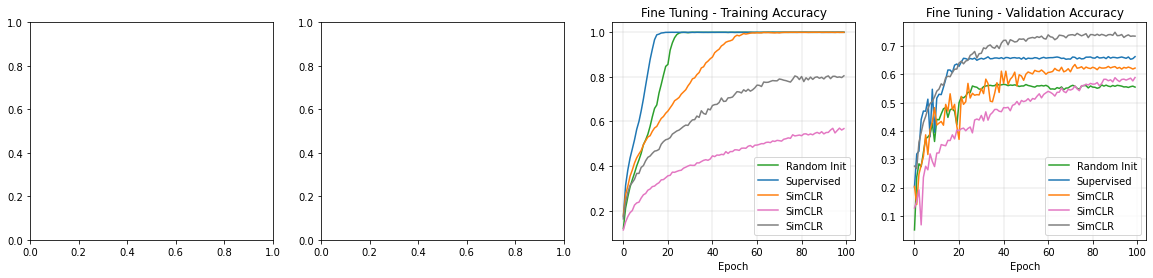

In [ ]:
d = 'caltech101_'
le_sv = eval(d+'le_sv')
le_ssl = eval(d+'le_ssl')
ft_rand = eval(d+'ft_rand')
ft_sv = eval(d+'ft_sv')
ft_ssl = eval(d+'ft_ssl')
ft_ssl_do = eval(d+'ft_ssl_do')
ft_ssl_do2 = eval(d+'ft_ssl_do2')

fig, ax = plt.subplots(1,4, figsize=(20, 4), sharey=False)

ax[2].plot(ft_rand['metrics_dict'][0]['train_acc'][:100], label='Random Init', color='tab:green')
ax[2].plot(ft_sv['metrics_dict'][0]['train_acc'], label='Supervised', color='tab:blue')
ax[2].plot(ft_ssl['metrics_dict'][0]['train_acc'], label='SimCLR', color='tab:orange')
ax[2].plot(ft_ssl_do['metrics_dict'][0]['train_acc'], label='SimCLR', color='tab:pink')
ax[2].plot(ft_ssl_do2['metrics_dict'][0]['train_acc'], label='SimCLR', color='tab:gray')
ax[2].legend()
ax[2].grid(linewidth=0.3)
ax[2].set_title('Fine Tuning - Training Accuracy')
ax[2].set_xlabel('Epoch')

ax[3].plot(ft_rand['metrics_dict'][0]['valid_acc'][:100], label='Random Init', color='tab:green')
ax[3].plot(ft_sv['metrics_dict'][0]['valid_acc'], label='Supervised', color='tab:blue')
ax[3].plot(ft_ssl['metrics_dict'][0]['valid_acc'], label='SimCLR', color='tab:orange')
ax[3].plot(ft_ssl_do['metrics_dict'][0]['valid_acc'], label='SimCLR', color='tab:pink')
ax[3].plot(ft_ssl_do2['metrics_dict'][0]['valid_acc'], label='SimCLR', color='tab:gray')
ax[3].legend()
ax[3].grid(linewidth=0.3)
ax[3].set_title('Fine Tuning - Validation Accuracy')
ax[3].set_xlabel('Epoch')

## Plotting

In [8]:
print(caltech101_le_sv)
print(caltech101_le_ssl)
print(caltech101_ft_rand)
print(caltech101_ft_sv)
print(caltech101_ft_ssl)

print(oxfordpets_le_sv)
print(oxfordpets_le_ssl)
print(oxfordpets_ft_rand)
print(oxfordpets_ft_sv)
print(oxfordpets_ft_ssl)

print(satlanduse_le_sv)
print(satlanduse_le_ssl)
print(satlanduse_ft_rand)
print(satlanduse_ft_sv)
print(satlanduse_ft_ssl)

print(braintumor_le_sv)
print(braintumor_le_ssl)
print(braintumor_ft_rand)
print(braintumor_ft_sv)
print(braintumor_ft_ssl)

   index    lr  wt_decay   val_acc  test_acc  \
0      0  0.01    0.0001  0.398618  0.406106   

                                        metrics_dict  
0  {'train_loss': [4.230864051943439, 3.933593291...  
   index    lr  wt_decay   val_acc  test_acc  \
0      0  0.01    0.0001  0.513825  0.490207   

                                        metrics_dict  
0  {'train_loss': [4.1094423590888205, 3.65672304...  
   index    lr  wt_decay   val_acc  test_acc  \
0      0  0.02    0.0001  0.673387  0.657834   

                                        metrics_dict  
0  {'train_loss': [7.207624630465403, 4.482568158...  
   index    lr  wt_decay  val_acc  test_acc  \
0      0  0.02    0.0001  0.77477  0.762673   

                                        metrics_dict  
0  {'train_loss': [3.9804216350075374, 3.42569511...  
   index    lr  wt_decay   val_acc  test_acc  \
0      0  0.02    0.0001  0.749424  0.729839   

                                        metrics_dict  
0  {'train_loss': [4.0

In [4]:
caltech101_le_sv = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/caltech101_result_le_sv.pkl')
caltech101_le_ssl = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/caltech101_result_le_ssl.pkl')
caltech101_ft_rand = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/caltech101_result_ft_rand_dropout.pkl')
caltech101_ft_sv = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/caltech101_result_ft_sv_dropout.pkl')
caltech101_ft_ssl = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/caltech101_result_ft_ssl_dropout2.pkl')

oxfordpets_le_sv = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/oxfordpets_result_le_sv.pkl')
oxfordpets_le_ssl = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/oxfordpets_result_le_ssl.pkl')
oxfordpets_ft_rand = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/oxfordpets_result_ft_rand.pkl')
oxfordpets_ft_sv = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/oxfordpets_result_ft_sv.pkl')
oxfordpets_ft_ssl = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/oxfordpets_result_ft_ssl.pkl')

satlanduse_le_sv = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_le_sv.pkl')
satlanduse_le_ssl = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_le_ssl.pkl')
satlanduse_ft_rand = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_ft_rand_dropout2.pkl')
satlanduse_ft_sv = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_ft_sv_dropout.pkl')
satlanduse_ft_ssl = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_ft_ssl_dropout.pkl')

braintumor_le_sv = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/braintumor_result_le_sv.pkl')
braintumor_le_ssl = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/braintumor_result_le_ssl.pkl')
braintumor_ft_rand = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/braintumor_result_ft_sv.pkl')
braintumor_ft_sv = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/braintumor_result_ft_sv.pkl')
braintumor_ft_ssl = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/braintumor_result_ft_ssl.pkl')

In [ ]:
# eval('caltech101'+'_'+'le_sv')


# fig, ax = plt.subplots(1,4, figsize=(12, 5), sharey=False)

# ax[0].plot(le_sv['metrics_dict'][0]['train_acc'], label='LE - Supervised')
# ax[0].plot(le_ssl['metrics_dict'][0]['train_acc'], label='LE - SimCLR')

# ax[0].legend()
# ax[0].grid(linewidth=0.3)
# ax[0].set_title('Training Accuracy')
# ax[0].set_xlabel('Epoch')

# ax[1].plot(le_sv['metrics_dict'][0]['valid_acc'], label='LE - Supervised')
# ax[1].plot(le_ssl['metrics_dict'][0]['valid_acc'], label='LE - SimCLR')

# ax[1].legend()
# ax[1].grid(linewidth=0.3)
# ax[1].set_title('Validation Accuracy')
# ax[1].set_xlabel('Epoch')

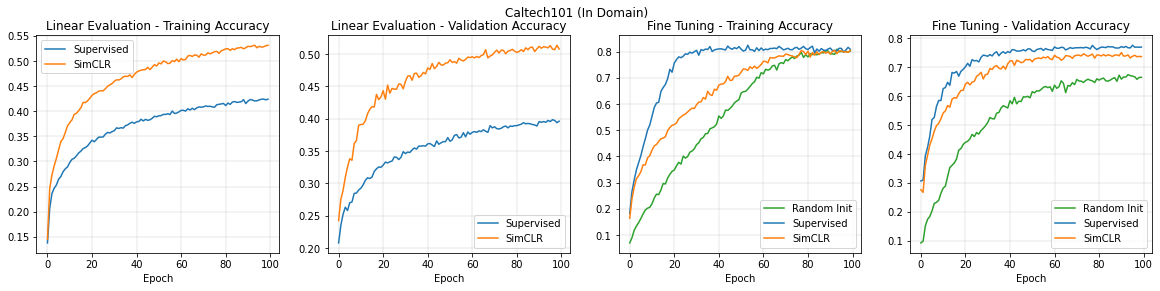

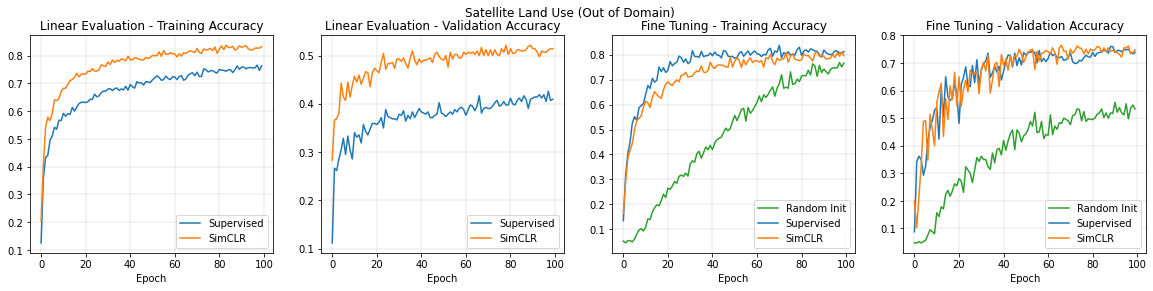

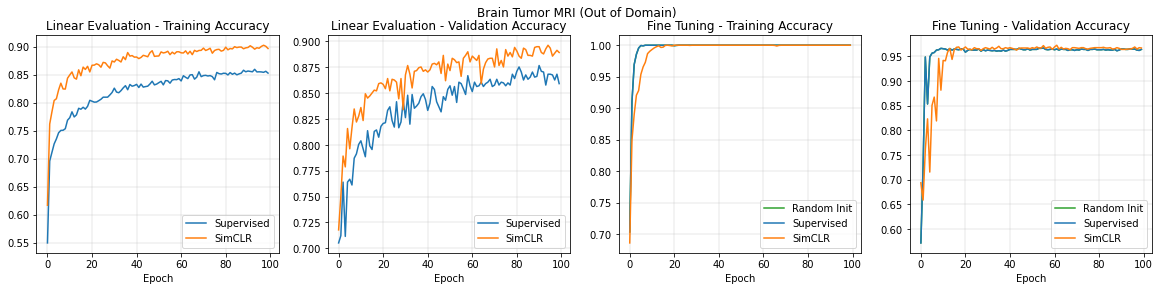

In [9]:
titles = {'caltech101_':'Caltech101 (In Domain)', 
          'oxfordpets_':'Oxford Pets (In Domain)', 
          'satlanduse_': 'Satellite Land Use (Out of Domain)',
          'braintumor_': 'Brain Tumor MRI (Out of Domain)'}

for d in ['caltech101_', 'satlanduse_', 'braintumor_']:
  le_sv = eval(d+'le_sv')
  le_ssl = eval(d+'le_ssl')
  ft_rand = eval(d+'ft_rand')
  ft_sv = eval(d+'ft_sv')
  ft_ssl = eval(d+'ft_ssl')

  fig, ax = plt.subplots(1,4, figsize=(20, 4), sharey=False)

  ax[0].plot(le_sv['metrics_dict'][0]['train_acc'], label='Supervised', color='tab:blue')
  ax[0].plot(le_ssl['metrics_dict'][0]['train_acc'], label='SimCLR', color='tab:orange')
  ax[0].legend()
  ax[0].grid(linewidth=0.3)
  ax[0].set_title('Linear Evaluation - Training Accuracy')
  ax[0].set_xlabel('Epoch')

  ax[1].plot(le_sv['metrics_dict'][0]['valid_acc'], label='Supervised', color='tab:blue')
  ax[1].plot(le_ssl['metrics_dict'][0]['valid_acc'], label='SimCLR', color='tab:orange')
  ax[1].legend()
  ax[1].grid(linewidth=0.3)
  ax[1].set_title('Linear Evaluation - Validation Accuracy')
  ax[1].set_xlabel('Epoch')

  ax[2].plot(ft_rand['metrics_dict'][0]['train_acc'][:100], label='Random Init', color='tab:green')
  ax[2].plot(ft_sv['metrics_dict'][0]['train_acc'], label='Supervised', color='tab:blue')
  ax[2].plot(ft_ssl['metrics_dict'][0]['train_acc'], label='SimCLR', color='tab:orange')
  ax[2].legend()
  ax[2].grid(linewidth=0.3)
  ax[2].set_title('Fine Tuning - Training Accuracy')
  ax[2].set_xlabel('Epoch')

  ax[3].plot(ft_rand['metrics_dict'][0]['valid_acc'][:100], label='Random Init', color='tab:green')
  ax[3].plot(ft_sv['metrics_dict'][0]['valid_acc'], label='Supervised', color='tab:blue')
  ax[3].plot(ft_ssl['metrics_dict'][0]['valid_acc'], label='SimCLR', color='tab:orange')
  ax[3].legend()
  ax[3].grid(linewidth=0.3)
  ax[3].set_title('Fine Tuning - Validation Accuracy')
  ax[3].set_xlabel('Epoch')

  fig.suptitle(titles[d])
  fig.show()

Text(0.5, 0, 'Epoch')

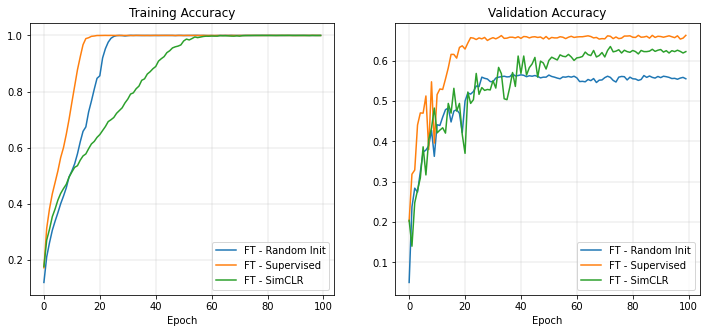

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12, 5), sharey=False)

ax[0].plot(ft_rand['metrics_dict'][0]['train_acc'][:100], label='FT - Random Init')
ax[0].plot(ft_sv['metrics_dict'][0]['train_acc'], label='FT - Supervised')
ax[0].plot(ft_ssl['metrics_dict'][0]['train_acc'], label='FT - SimCLR')

ax[0].legend()
ax[0].grid(linewidth=0.3)
ax[0].set_title('Training Accuracy')
ax[0].set_xlabel('Epoch')

ax[1].plot(ft_rand['metrics_dict'][0]['valid_acc'][:100], label='FT - Random Init')
ax[1].plot(ft_sv['metrics_dict'][0]['valid_acc'], label='FT - Supervised')
ax[1].plot(ft_ssl['metrics_dict'][0]['valid_acc'], label='FT - SimCLR')

ax[1].legend()
ax[1].grid(linewidth=0.3)
ax[1].set_title('Validation Accuracy')
ax[1].set_xlabel('Epoch')